In [1]:
import tracemalloc

from utils_v1 import *
import traceback


In [2]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADistanceMap, PAMultipleDates,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential
from src.trainer.multioutput import TrainerMCDropout, TrainerSingleRun
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric
import json
import pickle 
import src.trainer.evidential as evidential
from src.backend.Logger import Logger
import pdb


In [3]:

config = {
    "training": False,
    "inferring": True,
    "site" : 'MT',
    "training_date": "current", # values: earlier, current
    "mode" : 'mcd', # values: mcd, single_run, evidential
    "learning_rate": 1e-4,
    "weights": [0.1, 0.9, 0],
    "save_probabilities": False,
    "loadInference": False,
    "addPastDeforestationInput": True,
    "Uncertainty": {},
    "uncertainty_method": "pred_entropy", # values: pred_entropy, pred_variance, MI, KL
    }
print("Mode: {}. Site: {}. Training: {}. Training date: {}".format(
    config['mode'], config['site'], config['training'], config['training_date']))
print(config)


Mode: mcd. Site: MT. Training: False. Training date: current
{'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_method': 'pred_entropy'}


In [4]:


#dates = [2018, 2019]

if config['site'] == 'PA':
	if config['training_date'] == "earlier":
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]

	dataset = PAMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)


	
	if config['mode'] == 'mcd' or config['mode'] == 'single_run':
		if config['training_date'] == 'current':
			exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122]
		elif config['training_date'] == 'earlier':
			exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]
	if config['mode'] == 'evidential':	
		#exp_id_base = 148
		# exp_id_base = 155
		# exp_id_base = 194
		# exp_id_base = 198

		exp_id_base = 224 if config['training_date'] == 'earlier' else 214
else:
	if config['training_date'] == "earlier":
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]

	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)	
	if config['mode'] == 'evidential':	

		# MT
		# exp_id_base = 196
		# early date
		exp_id_base = 206
		# early date inference
		exp_id_base = 210
		exp_id_base = 210 if config['training_date'] == 'earlier' else 206

	elif config['mode'] == 'mcd' or config['mode'] == 'single_run':
		if config['training_date'] == 'current':
			exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
		elif config['training_date'] == 'earlier':
			exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	if config['mode'] == 'evidential':
		patchesHandler = PatchesHandlerEvidential(
			dataset)
	else:
		patchesHandler = PatchesHandlerMultipleDates(
			dataset)
		
else:
	patchesHandler = PatchesHandler()



ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2019, 2020]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:


if config['mode'] == 'evidential':
    config["inference_times"] = 1
    config['Uncertainty']['annealing_step'] = 10*375
    config['evidence_function'] = evidential.relu_evidence
    trainer_class = TrainerEvidential
    config['uncertainty_method'] = "evidential"
    config['classes_mode'] = None
    config['evidence_function']

    repetition_n = 10

    experiment_values = np.ones(repetition_n).astype(np.uint8)


    # experiment_values = [int(x) for x in experiment_values]

    exp_ids = range(exp_id_base, exp_id_base+len(experiment_values))

if config['mode'] == 'mcd':
    config["inference_times"] = 10
    trainer_class = TrainerMCDropout
    config['uncertainty_method'] = "pred_entropy"
    config['classes_mode'] = False

elif config['mode'] == 'single_run':
    config["inference_times"] = 1
    trainer_class = TrainerSingleRun
    config['uncertainty_method'] = "pred_entropy_single"
    config['classes_mode'] = False



In [6]:
exp_ids

[108, 109, 110, 111, 112, 113, 114, 115, 116, 117]

In [7]:
if config['training'] == True:
    idx = 0
    error_count = 0

    while idx < len(exp_ids):
    # for experiment_value, exp_id in zip(experiment_values, exp_ids):
        try:

            print("Beginning run number {}".format(idx))
            logger = Logger()
            trainer = trainer_class(config, dataset, patchesHandler, logger)

            trainer.defineExperiment(exp_ids[idx])

            trainer.setExperimentPath()
            trainer.createLogFolders()

            trainer.loadDataset()

            # %%
            if config["training"] == True:
                trainer.run()
            idx += 1
            print("Grid execution idx: {}".format(idx))            
        except Exception as e: 
            print(traceback.format_exc())
            error_count += 1
            if error_count > 10:
                sys.exit()
            print("Execution error in idx {}. Retrying...".format(idx))
            continue


In [8]:

if config['site'] == 'PA':

	dates = [2018, 2019]

	dataset = PAMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)	

elif config['site'] == 'MT':

	dates = [2019, 2020]

	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = True,
		borderBuffer = 2)	


ic(dates)

if issubclass(type(dataset), MultipleDates):
	if config['mode'] == 'evidential':
		patchesHandler = PatchesHandlerEvidential(
			dataset)
	else:
		patchesHandler = PatchesHandlerMultipleDates(
			dataset)
		
else:
	patchesHandler = PatchesHandler()



ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2019, 2020]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [9]:
trainer_class

src.trainer.multioutput.TrainerMCDropout

Beginning run number 0
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_method': 'pred_entropy', 'inference_times': 10, 'classes_mode': False, 'dropout_training': True}
D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp108/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172444421,   2559479], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172444421,   2559479], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172558781,   2445119], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174889540,    114360], dtype=int64))
ic| self.f1: 78.76, self.precision: 74.16, self.recall: 83.97
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11794548,)
ic| f1_val: 95.2
    precision_val: 93.03
    recall_val: 97.49
    mAP_val: 99.27


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174342439,    661461], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44615618,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44615618,) (44615618,)
0.7833864091210807
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.0060978415706352245
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1100040,)
    predicted_test_classified_incorrect.shape: (1100040,)
ic| TP_H + FN_H + FP_H + TN_H: 1100040
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1100040
    len(label_mask_current_deforestation_test): 44615618


[0.78077316 0.96615932 0.64557519 0.02465594 0.63556834 0.58518669
 0.1676039 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (701132,)
    predicted_test_classified_incorrect.shape: (701132,)
ic| TP_H + FN_H + FP_H + TN_H: 701132
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 701132
    len(label_mask_current_deforestation_test): 44615618


[0.76459486 0.95634897 0.72401198 0.01571495 0.62415256 0.47639304
 0.18353167]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1505892,)
    predicted_test_classified_incorrect.shape: (1505892,)
ic| TP_H + FN_H + FP_H + TN_H: 1505892
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1505892
    len(label_mask_current_deforestation_test): 44615618


[0.79687684 0.96995793 0.58395986 0.03375258 0.64020541 0.64275823
 0.14880522]
0.12380984262813237
threshold 0.12380984262813237


ic| label_current_deforestation_test_classified_incorrect.shape: (1522597,)
    predicted_test_classified_incorrect.shape: (1522597,)
ic| TP_H + FN_H + FP_H + TN_H: 1522597
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1522597
    len(label_mask_current_deforestation_test): 44615618


[0.79747988 0.97000917 0.58171008 0.034127   0.64042611 0.64460323
 0.14803872]
0.16016259581514075
threshold 0.16016259581514075


ic| label_current_deforestation_test_classified_incorrect.shape: (1296551,)
    predicted_test_classified_incorrect.shape: (1296551,)
ic| TP_H + FN_H + FP_H + TN_H: 1296551
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1296551
    len(label_mask_current_deforestation_test): 44615618


[0.78837298 0.9684683  0.61334554 0.02906047 0.63890094 0.6174296
 0.15823646]
0.17655479553116576
threshold 0.17655479553116576


ic| label_current_deforestation_test_classified_incorrect.shape: (1215282,)
    predicted_test_classified_incorrect.shape: (1215282,)
ic| TP_H + FN_H + FP_H + TN_H: 1215282
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1215282
    len(label_mask_current_deforestation_test): 44615618


[0.78514166 0.96762429 0.62598085 0.02723894 0.63798241 0.60544404
 0.16205435]
0.1538782906339315
threshold 0.1538782906339315


ic| label_current_deforestation_test_classified_incorrect.shape: (1330595,)
    predicted_test_classified_incorrect.shape: (1330595,)
ic| TP_H + FN_H + FP_H + TN_H: 1330595
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1330595
    len(label_mask_current_deforestation_test): 44615618


[0.78968104 0.96872553 0.60834152 0.02982353 0.63926591 0.62202833
 0.15658617]
0.14326105743320613
threshold 0.14326105743320613


ic| label_current_deforestation_test_classified_incorrect.shape: (1392176,)
    predicted_test_classified_incorrect.shape: (1392176,)
ic| TP_H + FN_H + FP_H + TN_H: 1392176
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1392176
    len(label_mask_current_deforestation_test): 44615618


[0.79224192 0.9692563  0.59956845 0.03120378 0.63953788 0.62970758
 0.15382014]
0.15231741668305251
threshold 0.15231741668305251


ic| label_current_deforestation_test_classified_incorrect.shape: (1339309,)
    predicted_test_classified_incorrect.shape: (1339309,)
ic| TP_H + FN_H + FP_H + TN_H: 1339309
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1339309
    len(label_mask_current_deforestation_test): 44615618


[0.79002828 0.96881641 0.60709488 0.03001884 0.63932484 0.62312536
 0.15618395]
0.1488581952639407
threshold 0.1488581952639407


ic| label_current_deforestation_test_classified_incorrect.shape: (1359072,)
    predicted_test_classified_incorrect.shape: (1359072,)
ic| TP_H + FN_H + FP_H + TN_H: 1359072
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1359072
    len(label_mask_current_deforestation_test): 44615618


[0.79085044 0.96898827 0.60426956 0.0304618  0.6394079  0.62562063
 0.15529001]
0.15199109868120259
threshold 0.15199109868120259


ic| label_current_deforestation_test_classified_incorrect.shape: (1341114,)
    predicted_test_classified_incorrect.shape: (1341114,)
ic| TP_H + FN_H + FP_H + TN_H: 1341114
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1341114
    len(label_mask_current_deforestation_test): 44615618


[0.79011216 0.96883777 0.60683623 0.03005929 0.63931716 0.62334933
 0.1561099 ]
0.15267426140768242
threshold 0.15267426140768242


ic| label_current_deforestation_test_classified_incorrect.shape: (1337321,)
    predicted_test_classified_incorrect.shape: (1337321,)
ic| TP_H + FN_H + FP_H + TN_H: 1337321
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1337321
    len(label_mask_current_deforestation_test): 44615618


[0.78996176 0.96879756 0.60740363 0.02997428 0.63927668 0.62285041
 0.15627964]
0.1524498523067888
threshold 0.1524498523067888


ic| label_current_deforestation_test_classified_incorrect.shape: (1338538,)
    predicted_test_classified_incorrect.shape: (1338538,)
ic| TP_H + FN_H + FP_H + TN_H: 1338538
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1338538
    len(label_mask_current_deforestation_test): 44615618


[0.79001467 0.96880623 0.60721605 0.03000156 0.63928456 0.62302052
 0.15622741]
0.15248318790131887
threshold 0.15248318790131887


ic| label_current_deforestation_test_classified_incorrect.shape: (1338358,)
    predicted_test_classified_incorrect.shape: (1338358,)
ic| TP_H + FN_H + FP_H + TN_H: 1338358
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1338358
    len(label_mask_current_deforestation_test): 44615618


[0.79001058 0.96880745 0.60724052 0.02999752 0.63927872 0.6229958
 0.15623927]
0.15241651671225875
threshold 0.15241651671225875


ic| label_current_deforestation_test_classified_incorrect.shape: (1338745,)
    predicted_test_classified_incorrect.shape: (1338745,)
ic| TP_H + FN_H + FP_H + TN_H: 1338745
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1338745
    len(label_mask_current_deforestation_test): 44615618
ic| self.threshold_optimal: 0.1524498523067888


[0.79001527 0.96880798 0.60717877 0.0300062  0.6393031  0.62305428
 0.15621427]
threshold 0.1524498523067888


ic| label_current_deforestation_test_classified_incorrect.shape: (1338538,)
    predicted_test_classified_incorrect.shape: (1338538,)
ic| TP_H + FN_H + FP_H + TN_H: 1338538
    len(label_mask_current_deforestation_test): 44615618
ic| TP_H + FN_H + FP_H + TN_H: 1338538
    len(label_mask_current_deforestation_test): 44615618


[0.79001467 0.96880623 0.60721605 0.03000156 0.63928456 0.62302052
 0.15622741]
threshold 0.1524498523067888
(44615618,) (44615618,)


ic| self.m_optimal: {'AA': array([0.03000156]),
                     'UEO': array([0.15622741]),
                     'f1': 78.76,
                     'f1_H': array([0.63104776]),
                     'f1_L': array([0.87032299]),
                     'precision_H': array([0.63928456]),
                     'precision_L': array([0.79001467]),
                     'recall_H': array([0.62302052]),
                     'recall_L': array([0.96880623]),
                     'recall_Ltotal': array([0.60721605])}
ic| self.m_audited_optimal: {'f1': array([0.91551737]),
                             'precision': array([0.8586521]),
                             'recall': array([0.98044877])}


cm_audited [[43618780   138529]
 [   16781   841528]]
[0.8586521  0.98044877]
Result idx 0: {'other_uncertainty_metrics': {'sUEO': 0.7833864091210807, 'ece_score': 0.0060978415706352245}, 'uncertainty_result': {'metrics': {'precision_L': array([0.79001467]), 'recall_L': array([0.96880623]), 'recall_Ltotal': array([0.60721605]), 'AA': array([0.03000156]), 'precision_H': array([0.63928456]), 'recall_H': array([0.62302052]), 'UEO': array([0.15622741]), 'f1_L': array([0.87032299]), 'f1_H': array([0.63104776]), 'f1': 78.76}, 'metrics_audited': {'precision': array([0.8586521]), 'recall': array([0.98044877]), 'f1': array([0.91551737])}, 'exp': 108}}
Grid execution idx: 0
Grid execution idx: 1
Beginning run number 1
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp109/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172421442,   2582458], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172421442,   2582458], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172566236,   2437664], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174859106,    144794], dtype=int64))
ic| self.f1: 80.47, self.precision: 76.11, self.recall: 85.36
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11791830,)
ic| f1_val: 96.7
    precision_val: 95.78
    recall_val: 97.63
    mAP_val: 99.47


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174409788,    594112], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44600050,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44600050,) (44600050,)
0.8067601893828018
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.005223661616781386
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1105902,)
    predicted_test_classified_incorrect.shape: (1105902,)
ic| TP_H + FN_H + FP_H + TN_H: 1105902
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1105902
    len(label_mask_current_deforestation_test): 44600050


[0.84954605 0.95577984 0.69565182 0.02479598 0.52183949 0.58028546
 0.17972063]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (703136,)
    predicted_test_classified_incorrect.shape: (703136,)
ic| TP_H + FN_H + FP_H + TN_H: 703136
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 703136
    len(label_mask_current_deforestation_test): 44600050


[0.8127454  0.94101796 0.76919742 0.01576536 0.48199514 0.46216476
 0.18115675]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1487679,)
    predicted_test_classified_incorrect.shape: (1487679,)
ic| TP_H + FN_H + FP_H + TN_H: 1487679
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1487679
    len(label_mask_current_deforestation_test): 44600050


[0.88200114 0.96345682 0.63064009 0.03335599 0.54846661 0.64539107
 0.16655396]
0.11468703326752237
threshold 0.11468703326752237


ic| label_current_deforestation_test_classified_incorrect.shape: (1561612,)
    predicted_test_classified_incorrect.shape: (1561612,)
ic| TP_H + FN_H + FP_H + TN_H: 1561612
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1561612
    len(label_mask_current_deforestation_test): 44600050


[0.88680785 0.9644115  0.61903184 0.03501368 0.55390587 0.65494567
 0.16300266]
0.15832094272163416
threshold 0.15832094272163416


ic| label_current_deforestation_test_classified_incorrect.shape: (1306462,)
    predicted_test_classified_incorrect.shape: (1306462,)
ic| TP_H + FN_H + FP_H + TN_H: 1306462
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1306462
    len(label_mask_current_deforestation_test): 44600050


[0.86693    0.96065042 0.6604598  0.02929284 0.53696498 0.61802384
 0.17358902]
0.1754165913238923
threshold 0.1754165913238923


ic| label_current_deforestation_test_classified_incorrect.shape: (1224772,)
    predicted_test_classified_incorrect.shape: (1224772,)
ic| TP_H + FN_H + FP_H + TN_H: 1224772
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1224772
    len(label_mask_current_deforestation_test): 44600050


[0.85984347 0.95889999 0.67448686 0.02746122 0.53134063 0.60382712
 0.17631034]
0.15290781239121584
threshold 0.15290781239121584


ic| label_current_deforestation_test_classified_incorrect.shape: (1334410,)
    predicted_test_classified_incorrect.shape: (1334410,)
ic| TP_H + FN_H + FP_H + TN_H: 1334410
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1334410
    len(label_mask_current_deforestation_test): 44600050


[0.86928795 0.96118972 0.65561983 0.02991947 0.53898151 0.62270939
 0.17258807]
0.1426612688938656
threshold 0.1426612688938656


ic| label_current_deforestation_test_classified_incorrect.shape: (1389862,)
    predicted_test_classified_incorrect.shape: (1389862,)
ic| TP_H + FN_H + FP_H + TN_H: 1389862
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1389862
    len(label_mask_current_deforestation_test): 44600050


[0.8740857  0.96212331 0.64645017 0.03116279 0.54234394 0.63131251
 0.1705573 ]
0.1515201463340613
threshold 0.1515201463340613


ic| label_current_deforestation_test_classified_incorrect.shape: (1341629,)
    predicted_test_classified_incorrect.shape: (1341629,)
ic| TP_H + FN_H + FP_H + TN_H: 1341629
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1341629
    len(label_mask_current_deforestation_test): 44600050


[0.86987975 0.96131478 0.65438776 0.03008133 0.53950185 0.62389556
 0.17230998]
0.15223098012121644
threshold 0.15223098012121644


ic| label_current_deforestation_test_classified_incorrect.shape: (1337893,)
    predicted_test_classified_incorrect.shape: (1337893,)
ic| TP_H + FN_H + FP_H + TN_H: 1337893
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1337893
    len(label_mask_current_deforestation_test): 44600050


[0.86956535 0.96124251 0.65499217 0.02999757 0.53927733 0.62333
 0.17244961]
0.15219764452993279
threshold 0.15219764452993279


ic| label_current_deforestation_test_classified_incorrect.shape: (1338058,)
    predicted_test_classified_incorrect.shape: (1338058,)
ic| TP_H + FN_H + FP_H + TN_H: 1338058
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1338058
    len(label_mask_current_deforestation_test): 44600050


[0.86958199 0.9612442  0.65496428 0.03000127 0.53928499 0.62335843
 0.17244452]
0.15205985826320567
threshold 0.15205985826320567


ic| label_current_deforestation_test_classified_incorrect.shape: (1338796,)
    predicted_test_classified_incorrect.shape: (1338796,)
ic| TP_H + FN_H + FP_H + TN_H: 1338796
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1338796
    len(label_mask_current_deforestation_test): 44600050


[0.8696626  0.96125281 0.65485618 0.03001781 0.53929426 0.6234657
 0.17242381]
0.152145014859226
threshold 0.152145014859226


ic| label_current_deforestation_test_classified_incorrect.shape: (1338349,)
    predicted_test_classified_incorrect.shape: (1338349,)
ic| TP_H + FN_H + FP_H + TN_H: 1338349
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1338349
    len(label_mask_current_deforestation_test): 44600050
ic| self.threshold_optimal: 0.15219764452993279


[0.8696142  0.96124647 0.65491778 0.03000779 0.53929209 0.62340656
 0.17243657]
threshold 0.15219764452993279


ic| label_current_deforestation_test_classified_incorrect.shape: (1338058,)
    predicted_test_classified_incorrect.shape: (1338058,)
ic| TP_H + FN_H + FP_H + TN_H: 1338058
    len(label_mask_current_deforestation_test): 44600050
ic| TP_H + FN_H + FP_H + TN_H: 1338058
    len(label_mask_current_deforestation_test): 44600050


[0.86958199 0.9612442  0.65496428 0.03000127 0.53928499 0.62335843
 0.17244452]
threshold 0.15219764452993279
(44600050,) (44600050,)


ic| self.m_optimal: {'AA': array([0.03000127]),
                     'UEO': array([0.17244452]),
                     'f1': 80.47,
                     'f1_H': array([0.57828194]),
                     'f1_L': array([0.91311851]),
                     'precision_H': array([0.53928499]),
                     'precision_L': array([0.86958199]),
                     'recall_H': array([0.62335843]),
                     'recall_L': array([0.9612442]),
                     'recall_Ltotal': array([0.65496428])}
ic| self.m_audited_optimal: {'f1': array([0.93984177]),
                             'precision': array([0.9083523]),
                             'recall': array([0.97359291])}


cm_audited [[43655202    84511]
 [   22719   837618]]
[0.9083523  0.97359291]
Result idx 1: {'other_uncertainty_metrics': {'sUEO': 0.8067601893828018, 'ece_score': 0.005223661616781386}, 'uncertainty_result': {'metrics': {'precision_L': array([0.86958199]), 'recall_L': array([0.9612442]), 'recall_Ltotal': array([0.65496428]), 'AA': array([0.03000127]), 'precision_H': array([0.53928499]), 'recall_H': array([0.62335843]), 'UEO': array([0.17244452]), 'f1_L': array([0.91311851]), 'f1_H': array([0.57828194]), 'f1': 80.47}, 'metrics_audited': {'precision': array([0.9083523]), 'recall': array([0.97359291]), 'f1': array([0.93984177])}, 'exp': 109}}
Grid execution idx: 1
Grid execution idx: 2
Beginning run number 2
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_me

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp110/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172614642,   2389258], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172614642,   2389258], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172773958,   2229942], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174844584,    159316], dtype=int64))
ic| self.f1: 84.6, self.precision: 82.73, self.recall: 86.57
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11791791,)
ic| f1_val: 97.33
    precision_val: 97.45
    recall_val: 97.2
    mAP_val: 99.55


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174449846,    554054], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44596687,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44596687,) (44596687,)
0.8261760517456648
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.009864540609972735
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1238004,)
    predicted_test_classified_incorrect.shape: (1238004,)
ic| TP_H + FN_H + FP_H + TN_H: 1238004
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1238004
    len(label_mask_current_deforestation_test): 44596687


[0.92446825 0.96746117 0.63556371 0.02776    0.64108803 0.6707582
 0.15958941]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (754236,)
    predicted_test_classified_incorrect.shape: (754236,)
ic| TP_H + FN_H + FP_H + TN_H: 754236
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 754236
    len(label_mask_current_deforestation_test): 44596687


[0.88694323 0.95742721 0.76514525 0.01691238 0.54709077 0.50056246
 0.18173002]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1660173,)
    predicted_test_classified_incorrect.shape: (1660173,)
ic| TP_H + FN_H + FP_H + TN_H: 1660173
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1660173
    len(label_mask_current_deforestation_test): 44596687


[0.9407157  0.97378237 0.54053484 0.03722638 0.68910427 0.7307946
 0.13444564]
0.20756943952900003
threshold 0.20756943952900003


ic| label_current_deforestation_test_classified_incorrect.shape: (1216940,)
    predicted_test_classified_incorrect.shape: (1216940,)
ic| TP_H + FN_H + FP_H + TN_H: 1216940
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1216940
    len(label_mask_current_deforestation_test): 44596687


[0.92325212 0.96711656 0.6415226  0.02728768 0.63755937 0.66580076
 0.16078473]
0.18010856591923774
threshold 0.18010856591923774


ic| label_current_deforestation_test_classified_incorrect.shape: (1349006,)
    predicted_test_classified_incorrect.shape: (1349006,)
ic| TP_H + FN_H + FP_H + TN_H: 1349006
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1349006
    len(label_mask_current_deforestation_test): 44596687


[0.93001592 0.96902168 0.60629333 0.03024902 0.65747371 0.69293085
 0.15286071]
0.15947225909379176
threshold 0.15947225909379176


ic| label_current_deforestation_test_classified_incorrect.shape: (1456936,)
    predicted_test_classified_incorrect.shape: (1456936,)
ic| TP_H + FN_H + FP_H + TN_H: 1456936
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1456936
    len(label_mask_current_deforestation_test): 44596687


[0.93462539 0.97066149 0.58135267 0.03266915 0.66991906 0.70889722
 0.14636045]
0.1823271693971603
threshold 0.1823271693971603


ic| label_current_deforestation_test_classified_incorrect.shape: (1337971,)
    predicted_test_classified_incorrect.shape: (1337971,)
ic| TP_H + FN_H + FP_H + TN_H: 1337971
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1337971
    len(label_mask_current_deforestation_test): 44596687


[0.92944308 0.9688623  0.60906957 0.03000158 0.6560721  0.69099376
 0.15349907]
0.1870559429565703
threshold 0.1870559429565703


ic| label_current_deforestation_test_classified_incorrect.shape: (1314517,)
    predicted_test_classified_incorrect.shape: (1314517,)
ic| TP_H + FN_H + FP_H + TN_H: 1314517
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1314517
    len(label_mask_current_deforestation_test): 44596687


[0.92827987 0.96851432 0.61494577 0.02947566 0.65298751 0.68680898
 0.15490101]
0.1829623882009355
threshold 0.1829623882009355


ic| label_current_deforestation_test_classified_incorrect.shape: (1334793,)
    predicted_test_classified_incorrect.shape: (1334793,)
ic| TP_H + FN_H + FP_H + TN_H: 1334793
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1334793
    len(label_mask_current_deforestation_test): 44596687


[0.92931594 0.9688218  0.60988124 0.02993032 0.65561117 0.69041452
 0.15370458]
0.18194539991899158
threshold 0.18194539991899158


ic| label_current_deforestation_test_classified_incorrect.shape: (1339861,)
    predicted_test_classified_incorrect.shape: (1339861,)
ic| TP_H + FN_H + FP_H + TN_H: 1339861
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1339861
    len(label_mask_current_deforestation_test): 44596687


[0.92955402 0.9688909  0.6085956  0.03004396 0.6562971  0.69132485
 0.15339621]
0.1823949534975569
threshold 0.1823949534975569


ic| label_current_deforestation_test_classified_incorrect.shape: (1337656,)
    predicted_test_classified_incorrect.shape: (1337656,)
ic| TP_H + FN_H + FP_H + TN_H: 1337656
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1337656
    len(label_mask_current_deforestation_test): 44596687


[0.92942623 0.96885801 0.60912779 0.02999452 0.65604824 0.69095397
 0.15351886]
0.182284244920673
threshold 0.182284244920673


ic| label_current_deforestation_test_classified_incorrect.shape: (1338184,)
    predicted_test_classified_incorrect.shape: (1338184,)
ic| TP_H + FN_H + FP_H + TN_H: 1338184
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1338184
    len(label_mask_current_deforestation_test): 44596687


[0.92945764 0.96886527 0.60902066 0.03000635 0.65609167 0.69102795
 0.15348804]
0.18236050543484258
threshold 0.18236050543484258


ic| label_current_deforestation_test_classified_incorrect.shape: (1337813,)
    predicted_test_classified_incorrect.shape: (1337813,)
ic| TP_H + FN_H + FP_H + TN_H: 1337813
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1337813
    len(label_mask_current_deforestation_test): 44596687
ic| self.threshold_optimal: 0.1823271693971603


[0.92943441 0.96886363 0.60909635 0.02999804 0.65606222 0.69097147
 0.15351067]
threshold 0.1823271693971603


ic| label_current_deforestation_test_classified_incorrect.shape: (1337971,)
    predicted_test_classified_incorrect.shape: (1337971,)
ic| TP_H + FN_H + FP_H + TN_H: 1337971
    len(label_mask_current_deforestation_test): 44596687
ic| TP_H + FN_H + FP_H + TN_H: 1337971
    len(label_mask_current_deforestation_test): 44596687


[0.92944308 0.9688623  0.60906957 0.03000158 0.6560721  0.69099376
 0.15349907]
threshold 0.1823271693971603
(44596687,) (44596687,)


ic| self.m_optimal: {'AA': array([0.03000158]),
                     'UEO': array([0.15349907]),
                     'f1': 84.6,
                     'f1_H': array([0.67308027]),
                     'f1_L': array([0.94874341]),
                     'precision_H': array([0.6560721]),
                     'precision_L': array([0.92944308]),
                     'recall_H': array([0.69099376]),
                     'recall_L': array([0.9688623]),
                     'recall_Ltotal': array([0.60906957])}
ic| self.m_audited_optimal: {'f1': array([0.96752744]),
                             'precision': array([0.95496437]),
                             'recall': array([0.98042547])}


cm_audited [[43698265    39704]
 [   16809   841909]]
[0.95496437 0.98042547]
Result idx 2: {'other_uncertainty_metrics': {'sUEO': 0.8261760517456648, 'ece_score': 0.009864540609972735}, 'uncertainty_result': {'metrics': {'precision_L': array([0.92944308]), 'recall_L': array([0.9688623]), 'recall_Ltotal': array([0.60906957]), 'AA': array([0.03000158]), 'precision_H': array([0.6560721]), 'recall_H': array([0.69099376]), 'UEO': array([0.15349907]), 'f1_L': array([0.94874341]), 'f1_H': array([0.67308027]), 'f1': 84.6}, 'metrics_audited': {'precision': array([0.95496437]), 'recall': array([0.98042547]), 'f1': array([0.96752744])}, 'exp': 110}}
Grid execution idx: 2
Grid execution idx: 3
Beginning run number 3
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_met

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp111/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172682555,   2321345], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172682555,   2321345], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172829022,   2174878], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174857433,    146467], dtype=int64))
ic| self.f1: 78.45, self.precision: 79.88, self.recall: 77.07
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11793611,)
ic| f1_val: 97.67
    precision_val: 98.89
    recall_val: 96.48
    mAP_val: 99.56


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174357354,    646546], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44597759,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44597759,) (44597759,)
0.8111663267477363
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.0050615225983896275
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1002044,)
    predicted_test_classified_incorrect.shape: (1002044,)
ic| TP_H + FN_H + FP_H + TN_H: 1002044
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1002044
    len(label_mask_current_deforestation_test): 44597759


[0.8802776  0.95813661 0.59142243 0.02246848 0.61189754 0.46852623
 0.24721799]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (668555,)
    predicted_test_classified_incorrect.shape: (668555,)
ic| TP_H + FN_H + FP_H + TN_H: 668555
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 668555
    len(label_mask_current_deforestation_test): 44597759


[0.84707588 0.94495448 0.67089615 0.01499078 0.57747942 0.34427822
 0.27848524]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1342540,)
    predicted_test_classified_incorrect.shape: (1342540,)
ic| TP_H + FN_H + FP_H + TN_H: 1342540
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1342540
    len(label_mask_current_deforestation_test): 44597759


[0.90006066 0.9652132  0.5313818  0.03010331 0.63909546 0.53254838
 0.20867945]
0.07849591857412197
threshold 0.07849591857412197


ic| label_current_deforestation_test_classified_incorrect.shape: (1747411,)
    predicted_test_classified_incorrect.shape: (1747411,)
ic| TP_H + FN_H + FP_H + TN_H: 1747411
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1747411
    len(label_mask_current_deforestation_test): 44597759


[0.91419002 0.97142671 0.4733749  0.03918159 0.66509269 0.58000582
 0.17300555]
0.14365909805294963
threshold 0.14365909805294963


ic| label_current_deforestation_test_classified_incorrect.shape: (1244899,)
    predicted_test_classified_incorrect.shape: (1244899,)
ic| TP_H + FN_H + FP_H + TN_H: 1244899
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1244899
    len(label_mask_current_deforestation_test): 44597759


[0.89559372 0.96352613 0.54658306 0.02791394 0.6321253  0.51802175
 0.21926266]
0.10790574247441723
threshold 0.10790574247441723


ic| label_current_deforestation_test_classified_incorrect.shape: (1466071,)
    predicted_test_classified_incorrect.shape: (1466071,)
ic| TP_H + FN_H + FP_H + TN_H: 1466071
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1466071
    len(label_mask_current_deforestation_test): 44597759


[0.9052164  0.96732813 0.51417618 0.0328732  0.6464252  0.5476881
 0.19647976]
0.12726649358425446
threshold 0.12726649358425446


ic| label_current_deforestation_test_classified_incorrect.shape: (1335385,)
    predicted_test_classified_incorrect.shape: (1335385,)
ic| TP_H + FN_H + FP_H + TN_H: 1335385
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1335385
    len(label_mask_current_deforestation_test): 44597759


[0.89973076 0.96508896 0.53247382 0.02994287 0.63861841 0.53154076
 0.20941493]
0.12877942549603408
threshold 0.12877942549603408


ic| label_current_deforestation_test_classified_incorrect.shape: (1326372,)
    predicted_test_classified_incorrect.shape: (1326372,)
ic| TP_H + FN_H + FP_H + TN_H: 1326372
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1326372
    len(label_mask_current_deforestation_test): 44597759


[0.89930523 0.96495012 0.53377953 0.02974078 0.63808078 0.5303227
 0.21036043]
0.12697895673453896
threshold 0.12697895673453896


ic| label_current_deforestation_test_classified_incorrect.shape: (1337121,)
    predicted_test_classified_incorrect.shape: (1337121,)
ic| TP_H + FN_H + FP_H + TN_H: 1337121
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1337121
    len(label_mask_current_deforestation_test): 44597759


[0.8998114  0.96512103 0.5322014  0.0299818  0.63873946 0.53179186
 0.20923782]
0.12677452865443428
threshold 0.12677452865443428


ic| label_current_deforestation_test_classified_incorrect.shape: (1338306,)
    predicted_test_classified_incorrect.shape: (1338306,)
ic| TP_H + FN_H + FP_H + TN_H: 1338306
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1338306
    len(label_mask_current_deforestation_test): 44597759


[0.89986435 0.96514028 0.53201822 0.03000837 0.63882221 0.5319621
 0.20911472]
0.12674117118414152
threshold 0.12674117118414152


ic| label_current_deforestation_test_classified_incorrect.shape: (1338519,)
    predicted_test_classified_incorrect.shape: (1338519,)
ic| TP_H + FN_H + FP_H + TN_H: 1338519
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1338519
    len(label_mask_current_deforestation_test): 44597759


[0.899884   0.96514033 0.53198652 0.03001314 0.63882475 0.53199377
 0.20909593]
0.12684684446055658
threshold 0.12684684446055658


ic| label_current_deforestation_test_classified_incorrect.shape: (1337909,)
    predicted_test_classified_incorrect.shape: (1337909,)
ic| TP_H + FN_H + FP_H + TN_H: 1337909
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1337909
    len(label_mask_current_deforestation_test): 44597759


[0.89983796 0.96513349 0.53207341 0.02999947 0.63880901 0.5319115
 0.2091523 ]
0.1268973068588868
threshold 0.1268973068588868


ic| label_current_deforestation_test_classified_incorrect.shape: (1337593,)
    predicted_test_classified_incorrect.shape: (1337593,)
ic| TP_H + FN_H + FP_H + TN_H: 1337593
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1337593
    len(label_mask_current_deforestation_test): 44597759


[0.89982308 0.96512839 0.53212273 0.02999238 0.63878743 0.53186561
 0.20918472]
0.1268135092457805
threshold 0.1268135092457805


ic| label_current_deforestation_test_classified_incorrect.shape: (1338106,)
    predicted_test_classified_incorrect.shape: (1338106,)
ic| TP_H + FN_H + FP_H + TN_H: 1338106
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1338106
    len(label_mask_current_deforestation_test): 44597759
ic| self.threshold_optimal: 0.12684684446055658


[0.89985661 0.9651359  0.5320464  0.03000388 0.63880902 0.53193689
 0.20913588]
threshold 0.12684684446055658


ic| label_current_deforestation_test_classified_incorrect.shape: (1337909,)
    predicted_test_classified_incorrect.shape: (1337909,)
ic| TP_H + FN_H + FP_H + TN_H: 1337909
    len(label_mask_current_deforestation_test): 44597759
ic| TP_H + FN_H + FP_H + TN_H: 1337909
    len(label_mask_current_deforestation_test): 44597759


[0.89983796 0.96513349 0.53207341 0.02999947 0.63880901 0.5319115
 0.2091523 ]
threshold 0.12684684446055658
(44597759,) (44597759,)


ic| self.m_optimal: {'AA': array([0.02999947]),
                     'UEO': array([0.2091523]),
                     'f1': 78.45,
                     'f1_H': array([0.58047989]),
                     'f1_L': array([0.93134268]),
                     'precision_H': array([0.63880901]),
                     'precision_L': array([0.89983796]),
                     'recall_H': array([0.5319115]),
                     'recall_L': array([0.96513349]),
                     'recall_Ltotal': array([0.53207341])}
ic| self.m_audited_optimal: {'f1': array([0.96154544]),
                             'precision': array([0.9430524]),
                             'recall': array([0.98077826])}


cm_audited [[43695680    50439]
 [   16370   835270]]
[0.9430524  0.98077826]
Result idx 3: {'other_uncertainty_metrics': {'sUEO': 0.8111663267477363, 'ece_score': 0.0050615225983896275}, 'uncertainty_result': {'metrics': {'precision_L': array([0.89983796]), 'recall_L': array([0.96513349]), 'recall_Ltotal': array([0.53207341]), 'AA': array([0.02999947]), 'precision_H': array([0.63880901]), 'recall_H': array([0.5319115]), 'UEO': array([0.2091523]), 'f1_L': array([0.93134268]), 'f1_H': array([0.58047989]), 'f1': 78.45}, 'metrics_audited': {'precision': array([0.9430524]), 'recall': array([0.98077826]), 'f1': array([0.96154544])}, 'exp': 111}}
Grid execution idx: 3
Grid execution idx: 4
Beginning run number 4
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_me

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp112/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172779732,   2224168], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172779732,   2224168], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172888191,   2115709], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174895441,    108459], dtype=int64))
ic| self.f1: 74.55, self.precision: 80.48, self.recall: 69.43
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11795166,)
ic| f1_val: 94.52
    precision_val: 92.06
    recall_val: 97.12
    mAP_val: 98.7


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174262259,    741641], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44618103,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44618103,) (44618103,)
0.7770624098741209
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.004566662255098621
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1056363,)
    predicted_test_classified_incorrect.shape: (1056363,)
ic| TP_H + FN_H + FP_H + TN_H: 1056363
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1056363
    len(label_mask_current_deforestation_test): 44618103


[0.8613474  0.93104835 0.54888881 0.02367566 0.64513638 0.35435641
 0.25311025]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (742991,)
    predicted_test_classified_incorrect.shape: (742991,)
ic| TP_H + FN_H + FP_H + TN_H: 742991
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 742991
    len(label_mask_current_deforestation_test): 44618103


[0.83828659 0.90392206 0.60145238 0.01665223 0.63961514 0.2775875
 0.28061028]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1352411,)
    predicted_test_classified_incorrect.shape: (1352411,)
ic| TP_H + FN_H + FP_H + TN_H: 1352411
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1352411
    len(label_mask_current_deforestation_test): 44618103


[0.87536297 0.94586361 0.50784312 0.03031081 0.66004697 0.40271902
 0.22163725]
0.07849591857412197
threshold 0.07849591857412197


ic| label_current_deforestation_test_classified_incorrect.shape: (1683432,)
    predicted_test_classified_incorrect.shape: (1683432,)
ic| TP_H + FN_H + FP_H + TN_H: 1683432
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1683432
    len(label_mask_current_deforestation_test): 44618103


[0.88499863 0.95682266 0.4701445  0.0377298  0.67637802 0.44077155
 0.19117377]
0.1437899297086489
threshold 0.1437899297086489


ic| label_current_deforestation_test_classified_incorrect.shape: (1268787,)
    predicted_test_classified_incorrect.shape: (1268787,)
ic| TP_H + FN_H + FP_H + TN_H: 1268787
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1268787
    len(label_mask_current_deforestation_test): 44618103


[0.87238981 0.94247277 0.51897315 0.0284366  0.65480433 0.39026496
 0.23047994]
0.10790574247441723
threshold 0.10790574247441723


ic| label_current_deforestation_test_classified_incorrect.shape: (1455442,)
    predicted_test_classified_incorrect.shape: (1455442,)
ic| TP_H + FN_H + FP_H + TN_H: 1455442
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1455442
    len(label_mask_current_deforestation_test): 44618103


[0.87873701 0.94970109 0.49533689 0.03261999 0.66553881 0.41594835
 0.21139242]
0.12851895445259048
threshold 0.12851895445259048


ic| label_current_deforestation_test_classified_incorrect.shape: (1340091,)
    predicted_test_classified_incorrect.shape: (1340091,)
ic| TP_H + FN_H + FP_H + TN_H: 1340091
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1340091
    len(label_mask_current_deforestation_test): 44618103


[0.87494657 0.94536064 0.50936887 0.03003469 0.65936075 0.40106949
 0.22291413]
0.1320012974170894
threshold 0.1320012974170894


ic| label_current_deforestation_test_classified_incorrect.shape: (1322904,)
    predicted_test_classified_incorrect.shape: (1322904,)
ic| TP_H + FN_H + FP_H + TN_H: 1322904
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1322904
    len(label_mask_current_deforestation_test): 44618103


[0.87438229 0.94470439 0.5116166  0.02964949 0.65826189 0.39857547
 0.22473524]
0.12894435895491393
threshold 0.12894435895491393


ic| label_current_deforestation_test_classified_incorrect.shape: (1338039,)
    predicted_test_classified_incorrect.shape: (1338039,)
ic| TP_H + FN_H + FP_H + TN_H: 1338039
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1338039
    len(label_mask_current_deforestation_test): 44618103


[0.87487917 0.94526678 0.50963523 0.0299887  0.65923211 0.40078331
 0.22312346]
0.13008136733155198
threshold 0.13008136733155198


ic| label_current_deforestation_test_classified_incorrect.shape: (1332369,)
    predicted_test_classified_incorrect.shape: (1332369,)
ic| TP_H + FN_H + FP_H + TN_H: 1332369
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1332369
    len(label_mask_current_deforestation_test): 44618103


[0.87470869 0.94505397 0.51040044 0.02986162 0.65882501 0.39993091
 0.22372741]
0.12898928185292688
threshold 0.12898928185292688


ic| label_current_deforestation_test_classified_incorrect.shape: (1337830,)
    predicted_test_classified_incorrect.shape: (1337830,)
ic| TP_H + FN_H + FP_H + TN_H: 1337830
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1337830
    len(label_mask_current_deforestation_test): 44618103


[0.8748689  0.94525997 0.50966911 0.02998402 0.65921839 0.40074434
 0.22314331]
0.12881285759998687
threshold 0.12881285759998687


ic| label_current_deforestation_test_classified_incorrect.shape: (1338691,)
    predicted_test_classified_incorrect.shape: (1338691,)
ic| TP_H + FN_H + FP_H + TN_H: 1338691
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1338691
    len(label_mask_current_deforestation_test): 44618103


[0.87490146 0.94528692 0.50955112 0.03000332 0.65927118 0.40087843
 0.2230532 ]
0.12870059658708202
threshold 0.12870059658708202


ic| label_current_deforestation_test_classified_incorrect.shape: (1339210,)
    predicted_test_classified_incorrect.shape: (1339210,)
ic| TP_H + FN_H + FP_H + TN_H: 1339210
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1339210
    len(label_mask_current_deforestation_test): 44618103


[0.87491524 0.94531704 0.50948453 0.03001495 0.65930815 0.40094668
 0.22300121]
0.12884619284392365
threshold 0.12884619284392365


ic| label_current_deforestation_test_classified_incorrect.shape: (1338544,)
    predicted_test_classified_incorrect.shape: (1338544,)
ic| TP_H + FN_H + FP_H + TN_H: 1338544
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1338544
    len(label_mask_current_deforestation_test): 44618103


[0.87489645 0.9452805  0.50956864 0.03000002 0.65926361 0.40085972
 0.22306847]
0.12887952808835487
threshold 0.12887952808835487


ic| label_current_deforestation_test_classified_incorrect.shape: (1338378,)
    predicted_test_classified_incorrect.shape: (1338378,)
ic| TP_H + FN_H + FP_H + TN_H: 1338378
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1338378
    len(label_mask_current_deforestation_test): 44618103
ic| self.threshold_optimal: 0.12884619284392365


[0.87489545 0.9452772  0.50959668 0.0299963  0.65924051 0.40082632
 0.22308843]
threshold 0.12884619284392365


ic| label_current_deforestation_test_classified_incorrect.shape: (1338544,)
    predicted_test_classified_incorrect.shape: (1338544,)
ic| TP_H + FN_H + FP_H + TN_H: 1338544
    len(label_mask_current_deforestation_test): 44618103
ic| TP_H + FN_H + FP_H + TN_H: 1338544
    len(label_mask_current_deforestation_test): 44618103


[0.87489645 0.9452805  0.50956864 0.03000002 0.65926361 0.40085972
 0.22306847]
threshold 0.12884619284392365
(44618103,) (44618103,)


ic| self.m_optimal: {'AA': array([0.03000002]),
                     'UEO': array([0.22306847]),
                     'f1': 74.55,
                     'f1_H': array([0.49856883]),
                     'f1_L': array([0.90872764]),
                     'precision_H': array([0.65926361]),
                     'precision_L': array([0.87489645]),
                     'recall_H': array([0.40085972]),
                     'recall_L': array([0.9452805]),
                     'recall_Ltotal': array([0.50956864])}
ic| self.m_audited_optimal: {'f1': array([0.94990529]),
                             'precision': array([0.93016413]),
                             'recall': array([0.97050257])}


cm_audited [[43699760    62370]
 [   25249   830724]]
[0.93016413 0.97050257]
Result idx 4: {'other_uncertainty_metrics': {'sUEO': 0.7770624098741209, 'ece_score': 0.004566662255098621}, 'uncertainty_result': {'metrics': {'precision_L': array([0.87489645]), 'recall_L': array([0.9452805]), 'recall_Ltotal': array([0.50956864]), 'AA': array([0.03000002]), 'precision_H': array([0.65926361]), 'recall_H': array([0.40085972]), 'UEO': array([0.22306847]), 'f1_L': array([0.90872764]), 'f1_H': array([0.49856883]), 'f1': 74.55}, 'metrics_audited': {'precision': array([0.93016413]), 'recall': array([0.97050257]), 'f1': array([0.94990529])}, 'exp': 112}}
Grid execution idx: 4
Grid execution idx: 5
Beginning run number 5
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_m

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp113/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172984848,   2019052], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172984848,   2019052], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([173103487,   1900413], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174885261,    118639], dtype=int64))
ic| self.f1: 79.33, self.precision: 90.98, self.recall: 70.32
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11793062,)
ic| f1_val: 96.18
    precision_val: 95.08
    recall_val: 97.3
    mAP_val: 99.28


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174375921,    627979], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44612838,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44612838,) (44612838,)
0.7974513813291221
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.005923865952585499
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1117366,)
    predicted_test_classified_incorrect.shape: (1117366,)
ic| TP_H + FN_H + FP_H + TN_H: 1117366
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1117366
    len(label_mask_current_deforestation_test): 44612838


[0.96913007 0.91058706 0.54686562 0.02504584 0.74935777 0.39142942
 0.21467715]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (729043,)
    predicted_test_classified_incorrect.shape: (729043,)
ic| TP_H + FN_H + FP_H + TN_H: 729043
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 729043
    len(label_mask_current_deforestation_test): 44612838


[0.94434296 0.85611393 0.60851389 0.01634155 0.7366786  0.32744906
 0.23078948]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1458628,)
    predicted_test_classified_incorrect.shape: (1458628,)
ic| TP_H + FN_H + FP_H + TN_H: 1458628
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1458628
    len(label_mask_current_deforestation_test): 44612838


[0.97543975 0.93414397 0.49727445 0.03269525 0.78264362 0.44035966
 0.18214638]
0.09162279546564989
threshold 0.09162279546564989


ic| label_current_deforestation_test_classified_incorrect.shape: (1683100,)
    predicted_test_classified_incorrect.shape: (1683100,)
ic| TP_H + FN_H + FP_H + TN_H: 1683100
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1683100
    len(label_mask_current_deforestation_test): 44612838


[0.97653795 0.94274801 0.46922725 0.03772681 0.80015254 0.46585728
 0.16293919]
0.1552562769963952
threshold 0.1552562769963952


ic| label_current_deforestation_test_classified_incorrect.shape: (1311724,)
    predicted_test_classified_incorrect.shape: (1311724,)
ic| TP_H + FN_H + FP_H + TN_H: 1311724
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1311724
    len(label_mask_current_deforestation_test): 44612838


[0.97363727 0.92667511 0.51757943 0.02940239 0.76919988 0.42050174
 0.19633264]
0.15765082113017942
threshold 0.15765082113017942


ic| label_current_deforestation_test_classified_incorrect.shape: (1300701,)
    predicted_test_classified_incorrect.shape: (1300701,)
ic| TP_H + FN_H + FP_H + TN_H: 1300701
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1300701
    len(label_mask_current_deforestation_test): 44612838


[0.97344309 0.9260262  0.51921429 0.02915531 0.76810845 0.41884481
 0.19742663]
0.14715114797352272
threshold 0.14715114797352272


ic| label_current_deforestation_test_classified_incorrect.shape: (1349832,)
    predicted_test_classified_incorrect.shape: (1349832,)
ic| TP_H + FN_H + FP_H + TN_H: 1349832
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1349832
    len(label_mask_current_deforestation_test): 44612838


[0.97419717 0.9288484  0.51218438 0.03025658 0.77284194 0.42585887
 0.19256197]
0.14758903654745698
threshold 0.14758903654745698


ic| label_current_deforestation_test_classified_incorrect.shape: (1347592,)
    predicted_test_classified_incorrect.shape: (1347592,)
ic| TP_H + FN_H + FP_H + TN_H: 1347592
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1347592
    len(label_mask_current_deforestation_test): 44612838


[0.97414367 0.92871472 0.51250435 0.03020637 0.77266448 0.42554772
 0.19276804]
0.15017459850467652
threshold 0.15017459850467652


ic| label_current_deforestation_test_classified_incorrect.shape: (1335311,)
    predicted_test_classified_incorrect.shape: (1335311,)
ic| TP_H + FN_H + FP_H + TN_H: 1335311
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1335311
    len(label_mask_current_deforestation_test): 44612838


[0.97398076 0.92804126 0.5142373  0.02993109 0.77147978 0.42382554
 0.1939872 ]
0.1502079340654591
threshold 0.1502079340654591


ic| label_current_deforestation_test_classified_incorrect.shape: (1335143,)
    predicted_test_classified_incorrect.shape: (1335143,)
ic| TP_H + FN_H + FP_H + TN_H: 1335143
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1335143
    len(label_mask_current_deforestation_test): 44612838


[0.97398186 0.92803631 0.51425949 0.02992733 0.77145908 0.4238013
 0.19400734]
0.149300877612024
threshold 0.149300877612024


ic| label_current_deforestation_test_classified_incorrect.shape: (1339550,)
    predicted_test_classified_incorrect.shape: (1339550,)
ic| TP_H + FN_H + FP_H + TN_H: 1339550
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1339550
    len(label_mask_current_deforestation_test): 44612838


[0.97403975 0.92827311 0.51364058 0.03002611 0.77188461 0.4244202
 0.19356511]
0.14864701250869722
threshold 0.14864701250869722


ic| label_current_deforestation_test_classified_incorrect.shape: (1342598,)
    predicted_test_classified_incorrect.shape: (1342598,)
ic| TP_H + FN_H + FP_H + TN_H: 1342598
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1342598
    len(label_mask_current_deforestation_test): 44612838


[0.97407989 0.9284569  0.51322836 0.03009443 0.77216421 0.42481663
 0.19326821]
0.1493905369180805
threshold 0.1493905369180805


ic| label_current_deforestation_test_classified_incorrect.shape: (1339110,)
    predicted_test_classified_incorrect.shape: (1339110,)
ic| TP_H + FN_H + FP_H + TN_H: 1339110
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1339110
    len(label_mask_current_deforestation_test): 44612838


[0.97403276 0.92824588 0.51371765 0.03001625 0.77183136 0.42434195
 0.19360592]
0.14961695505824876
threshold 0.14961695505824876


ic| label_current_deforestation_test_classified_incorrect.shape: (1337992,)
    predicted_test_classified_incorrect.shape: (1337992,)
ic| TP_H + FN_H + FP_H + TN_H: 1337992
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1337992
    len(label_mask_current_deforestation_test): 44612838


[0.97401425 0.92819281 0.51386712 0.02999119 0.77173644 0.42419026
 0.19372008]
0.14982995590118053
threshold 0.14982995590118053


ic| label_current_deforestation_test_classified_incorrect.shape: (1337017,)
    predicted_test_classified_incorrect.shape: (1337017,)
ic| TP_H + FN_H + FP_H + TN_H: 1337017
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1337017
    len(label_mask_current_deforestation_test): 44612838


[0.97400367 0.928136   0.51400258 0.02996933 0.77163974 0.42405764
 0.19381695]
0.14957100709255644
threshold 0.14957100709255644


ic| label_current_deforestation_test_classified_incorrect.shape: (1338225,)
    predicted_test_classified_incorrect.shape: (1338225,)
ic| TP_H + FN_H + FP_H + TN_H: 1338225
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1338225
    len(label_mask_current_deforestation_test): 44612838


[0.97401922 0.92820453 0.51383676 0.02999641 0.77175367 0.42422055
 0.19369695]
0.14952397253803001
threshold 0.14952397253803001


ic| label_current_deforestation_test_classified_incorrect.shape: (1338463,)
    predicted_test_classified_incorrect.shape: (1338463,)
ic| TP_H + FN_H + FP_H + TN_H: 1338463
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1338463
    len(label_mask_current_deforestation_test): 44612838


[0.97402618 0.92821776 0.5138029  0.03000175 0.77177047 0.42425423
 0.19367486]
0.14949063698689777
threshold 0.14949063698689777


ic| label_current_deforestation_test_classified_incorrect.shape: (1338634,)
    predicted_test_classified_incorrect.shape: (1338634,)
ic| TP_H + FN_H + FP_H + TN_H: 1338634
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1338634
    len(label_mask_current_deforestation_test): 44612838
ic| self.threshold_optimal: 0.14952397253803001


[0.97402724 0.92823055 0.51378071 0.03000558 0.77178743 0.42427397
 0.1936587 ]
threshold 0.14952397253803001


ic| label_current_deforestation_test_classified_incorrect.shape: (1338463,)
    predicted_test_classified_incorrect.shape: (1338463,)
ic| TP_H + FN_H + FP_H + TN_H: 1338463
    len(label_mask_current_deforestation_test): 44612838
ic| TP_H + FN_H + FP_H + TN_H: 1338463
    len(label_mask_current_deforestation_test): 44612838


[0.97402618 0.92821776 0.5138029  0.03000175 0.77177047 0.42425423
 0.19367486]
threshold 0.14952397253803001
(44612838,) (44612838,)


ic| self.m_optimal: {'AA': array([0.03000175]),
                     'UEO': array([0.19367486]),
                     'f1': 79.33,
                     'f1_H': array([0.5475253]),
                     'f1_L': array([0.95057041]),
                     'precision_H': array([0.77177047]),
                     'precision_L': array([0.97402618]),
                     'recall_H': array([0.42425423]),
                     'recall_L': array([0.92821776]),
                     'recall_Ltotal': array([0.5138029])}
ic| self.m_audited_optimal: {'f1': array([0.97292993]),
                             'precision': array([0.98593248]),
                             'recall': array([0.96026588])}


cm_audited [[43744763    11733]
 [   34026   822316]]
[0.98593248 0.96026588]
Result idx 5: {'other_uncertainty_metrics': {'sUEO': 0.7974513813291221, 'ece_score': 0.005923865952585499}, 'uncertainty_result': {'metrics': {'precision_L': array([0.97402618]), 'recall_L': array([0.92821776]), 'recall_Ltotal': array([0.5138029]), 'AA': array([0.03000175]), 'precision_H': array([0.77177047]), 'recall_H': array([0.42425423]), 'UEO': array([0.19367486]), 'f1_L': array([0.95057041]), 'f1_H': array([0.5475253]), 'f1': 79.33}, 'metrics_audited': {'precision': array([0.98593248]), 'recall': array([0.96026588]), 'f1': array([0.97292993])}, 'exp': 113}}
Grid execution idx: 5
Grid execution idx: 6
Beginning run number 6
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_me

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp114/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172890606,   2113294], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172890606,   2113294], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172974184,   2029716], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174920322,     83578], dtype=int64))
ic| self.f1: 77.66, self.precision: 86.29, self.recall: 70.6
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11797223,)
ic| f1_val: 97.21
    precision_val: 98.17
    recall_val: 96.27
    mAP_val: 99.42


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174411818,    592082], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44624107,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))
d:\Jorge\deforestation_uncertainty\src\plot.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 4)


(44624107,) (44624107,)
0.7809355164565891
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.005661825451459615
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (949378,)
    predicted_test_classified_incorrect.shape: (949378,)
ic| TP_H + FN_H + FP_H + TN_H: 949378
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 949378
    len(label_mask_current_deforestation_test): 44624107


[0.89578844 0.84194615 0.58071467 0.021275   0.73727104 0.40395436
 0.1793699 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (584367,)
    predicted_test_classified_incorrect.shape: (584367,)
ic| TP_H + FN_H + FP_H + TN_H: 584367
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 584367
    len(label_mask_current_deforestation_test): 44624107


[0.88648884 0.81015252 0.63275428 0.01309532 0.70142597 0.33473112
 0.19468507]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1325502,)
    predicted_test_classified_incorrect.shape: (1325502,)
ic| TP_H + FN_H + FP_H + TN_H: 1325502
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1325502
    len(label_mask_current_deforestation_test): 44624107


[0.90222666 0.87960249 0.53825358 0.02970372 0.75690498 0.432385
 0.16391304]
0.07849591857412197
threshold 0.07849591857412197


ic| label_current_deforestation_test_classified_incorrect.shape: (1765793,)
    predicted_test_classified_incorrect.shape: (1765793,)
ic| TP_H + FN_H + FP_H + TN_H: 1765793
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1765793
    len(label_mask_current_deforestation_test): 44624107


[0.90734613 0.92865104 0.50069273 0.03957038 0.77071592 0.4456164
 0.14779538]
0.14217571429069603
threshold 0.14217571429069603


ic| label_current_deforestation_test_classified_incorrect.shape: (1226319,)
    predicted_test_classified_incorrect.shape: (1226319,)
ic| TP_H + FN_H + FP_H + TN_H: 1226319
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1226319
    len(label_mask_current_deforestation_test): 44624107


[0.90102107 0.86862151 0.54830746 0.02748109 0.75211837 0.42776319
 0.16767939]
0.10790574247441723
threshold 0.10790574247441723


ic| label_current_deforestation_test_classified_incorrect.shape: (1461136,)
    predicted_test_classified_incorrect.shape: (1461136,)
ic| TP_H + FN_H + FP_H + TN_H: 1461136
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1461136
    len(label_mask_current_deforestation_test): 44624107


[0.90381463 0.89569538 0.52544039 0.0327432  0.76234724 0.43691832
 0.1592308 ]
0.12545191994341331
threshold 0.12545191994341331


ic| label_current_deforestation_test_classified_incorrect.shape: (1329749,)
    predicted_test_classified_incorrect.shape: (1329749,)
ic| TP_H + FN_H + FP_H + TN_H: 1329749
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1329749
    len(label_mask_current_deforestation_test): 44624107


[0.90229801 0.88004777 0.5378305  0.02979889 0.75705109 0.43259416
 0.16375002]
0.11874987652289441
threshold 0.11874987652289441


ic| label_current_deforestation_test_classified_incorrect.shape: (1376957,)
    predicted_test_classified_incorrect.shape: (1376957,)
ic| TP_H + FN_H + FP_H + TN_H: 1376957
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1376957
    len(label_mask_current_deforestation_test): 44624107


[0.90286327 0.88562516 0.5332615  0.0308568  0.75905152 0.43428383
 0.16212094]
0.12354202476864798
threshold 0.12354202476864798


ic| label_current_deforestation_test_classified_incorrect.shape: (1342878,)
    predicted_test_classified_incorrect.shape: (1342878,)
ic| TP_H + FN_H + FP_H + TN_H: 1342878
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1342878
    len(label_mask_current_deforestation_test): 44624107


[0.90244532 0.8815302  0.5365264  0.03009311 0.75766092 0.43315514
 0.16326417]
0.12373700295330269
threshold 0.12373700295330269


ic| label_current_deforestation_test_classified_incorrect.shape: (1341531,)
    predicted_test_classified_incorrect.shape: (1341531,)
ic| TP_H + FN_H + FP_H + TN_H: 1341531
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1341531
    len(label_mask_current_deforestation_test): 44624107


[0.90243082 0.88137479 0.53665309 0.03006292 0.75760238 0.43310926
 0.16331383]
0.12426756835100573
threshold 0.12426756835100573


ic| label_current_deforestation_test_classified_incorrect.shape: (1337872,)
    predicted_test_classified_incorrect.shape: (1337872,)
ic| TP_H + FN_H + FP_H + TN_H: 1337872
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1337872
    len(label_mask_current_deforestation_test): 44624107


[0.90239063 0.88096527 0.53700992 0.02998092 0.75743577 0.43295863
 0.16345234]
0.12471995040467537
threshold 0.12471995040467537


ic| label_current_deforestation_test_classified_incorrect.shape: (1334743,)
    predicted_test_classified_incorrect.shape: (1334743,)
ic| TP_H + FN_H + FP_H + TN_H: 1334743
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1334743
    len(label_mask_current_deforestation_test): 44624107


[0.90237318 0.88062519 0.53732258 0.02991081 0.7572495  0.43281237
 0.16358222]
0.12417319703682955
threshold 0.12417319703682955


ic| label_current_deforestation_test_classified_incorrect.shape: (1338522,)
    predicted_test_classified_incorrect.shape: (1338522,)
ic| TP_H + FN_H + FP_H + TN_H: 1338522
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1338522
    len(label_mask_current_deforestation_test): 44624107


[0.90239719 0.88102435 0.5369425  0.02999549 0.75746958 0.4330011
 0.16342161]
0.12407833774026752
threshold 0.12407833774026752


ic| label_current_deforestation_test_classified_incorrect.shape: (1339154,)
    predicted_test_classified_incorrect.shape: (1339154,)
ic| TP_H + FN_H + FP_H + TN_H: 1339154
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1339154
    len(label_mask_current_deforestation_test): 44624107


[0.90240057 0.88111956 0.53688788 0.03000965 0.75750131 0.43299923
 0.16340656]
0.12413986186171007
threshold 0.12413986186171007


ic| label_current_deforestation_test_classified_incorrect.shape: (1338722,)
    predicted_test_classified_incorrect.shape: (1338722,)
ic| TP_H + FN_H + FP_H + TN_H: 1338722
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1338722
    len(label_mask_current_deforestation_test): 44624107
ic| self.threshold_optimal: 0.12413986186171007


[0.90239648 0.88106005 0.53692739 0.02999997 0.75748205 0.4329934
 0.16341833]
threshold 0.12413986186171007


ic| label_current_deforestation_test_classified_incorrect.shape: (1338722,)
    predicted_test_classified_incorrect.shape: (1338722,)
ic| TP_H + FN_H + FP_H + TN_H: 1338722
    len(label_mask_current_deforestation_test): 44624107
ic| TP_H + FN_H + FP_H + TN_H: 1338722
    len(label_mask_current_deforestation_test): 44624107


[0.90239648 0.88106005 0.53692739 0.02999997 0.75748205 0.4329934
 0.16341833]
threshold 0.12413986186171007
(44624107,) (44624107,)


ic| self.m_optimal: {'AA': array([0.02999997]),
                     'UEO': array([0.16341833]),
                     'f1': 77.66,
                     'f1_H': array([0.55101469]),
                     'f1_L': array([0.89160063]),
                     'precision_H': array([0.75748205]),
                     'precision_L': array([0.90239648]),
                     'recall_H': array([0.4329934]),
                     'recall_L': array([0.88106005]),
                     'recall_Ltotal': array([0.53692739])}
ic| self.m_audited_optimal: {'f1': array([0.93424752]),
                             'precision': array([0.94107672]),
                             'recall': array([0.92751673])}


cm_audited [[43713778    49965]
 [   62362   798002]]
[0.94107672 0.92751673]
Result idx 6: {'other_uncertainty_metrics': {'sUEO': 0.7809355164565891, 'ece_score': 0.005661825451459615}, 'uncertainty_result': {'metrics': {'precision_L': array([0.90239648]), 'recall_L': array([0.88106005]), 'recall_Ltotal': array([0.53692739]), 'AA': array([0.02999997]), 'precision_H': array([0.75748205]), 'recall_H': array([0.4329934]), 'UEO': array([0.16341833]), 'f1_L': array([0.89160063]), 'f1_H': array([0.55101469]), 'f1': 77.66}, 'metrics_audited': {'precision': array([0.94107672]), 'recall': array([0.92751673]), 'f1': array([0.93424752])}, 'exp': 114}}
Grid execution idx: 6
Grid execution idx: 7
Beginning run number 7
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_m

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp115/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172594899,   2409001], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172594899,   2409001], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172710924,   2292976], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174887875,    116025], dtype=int64))
ic| self.f1: 82.23, self.precision: 80.19, self.recall: 84.37
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11793636,)
ic| f1_val: 96.49
    precision_val: 96.13
    recall_val: 96.84
    mAP_val: 99.37


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174478362,    525538], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44614295,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44614295,) (44614295,)
0.8201435721529072
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.004854691024227627
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (950476,)
    predicted_test_classified_incorrect.shape: (950476,)
ic| TP_H + FN_H + FP_H + TN_H: 950476
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 950476
    len(label_mask_current_deforestation_test): 44614295


[0.84414203 0.96271857 0.68248405 0.02130429 0.66183928 0.55368867
 0.1686344 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (597025,)
    predicted_test_classified_incorrect.shape: (597025,)
ic| TP_H + FN_H + FP_H + TN_H: 597025
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 597025
    len(label_mask_current_deforestation_test): 44614295


[0.82887493 0.94690375 0.75898552 0.01338192 0.62105146 0.42664438
 0.18503496]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1278120,)
    predicted_test_classified_incorrect.shape: (1278120,)
ic| TP_H + FN_H + FP_H + TN_H: 1278120
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1278120
    len(label_mask_current_deforestation_test): 44614295


[0.85961013 0.96951971 0.62079007 0.02864822 0.67568035 0.61959849
 0.15156639]
0.07849591857412197
threshold 0.07849591857412197


ic| label_current_deforestation_test_classified_incorrect.shape: (1616755,)
    predicted_test_classified_incorrect.shape: (1616755,)
ic| TP_H + FN_H + FP_H + TN_H: 1616755
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1616755
    len(label_mask_current_deforestation_test): 44614295


[0.87534553 0.97334827 0.56539643 0.0362385  0.68519405 0.66390905
 0.13586255]
0.13458412811646714
threshold 0.13458412811646714


ic| label_current_deforestation_test_classified_incorrect.shape: (1232957,)
    predicted_test_classified_incorrect.shape: (1232957,)
ic| TP_H + FN_H + FP_H + TN_H: 1232957
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1232957
    len(label_mask_current_deforestation_test): 44614295


[0.85752719 0.96877947 0.62883165 0.02763592 0.67404865 0.61220239
 0.1538403 ]
0.11527576858824046
threshold 0.11527576858824046


ic| label_current_deforestation_test_classified_incorrect.shape: (1340227,)
    predicted_test_classified_incorrect.shape: (1340227,)
ic| TP_H + FN_H + FP_H + TN_H: 1340227
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1340227
    len(label_mask_current_deforestation_test): 44614295


[0.8627511  0.97034056 0.61037059 0.0300403  0.67708154 0.62884618
 0.14856496]
0.1012271159839705
threshold 0.1012271159839705


ic| label_current_deforestation_test_classified_incorrect.shape: (1430846,)
    predicted_test_classified_incorrect.shape: (1430846,)
ic| TP_H + FN_H + FP_H + TN_H: 1430846
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1430846
    len(label_mask_current_deforestation_test): 44614295


[0.86692353 0.97145093 0.5952698  0.03207147 0.67982224 0.64143157
 0.1441908 ]
0.11500764430460415
threshold 0.11500764430460415


ic| label_current_deforestation_test_classified_incorrect.shape: (1341801,)
    predicted_test_classified_incorrect.shape: (1341801,)
ic| TP_H + FN_H + FP_H + TN_H: 1341801
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1341801
    len(label_mask_current_deforestation_test): 44614295


[0.8628448  0.97036516 0.61009242 0.03007558 0.67710435 0.62908287
 0.14850232]
0.11802214336996784
threshold 0.11802214336996784


ic| label_current_deforestation_test_classified_incorrect.shape: (1323967,)
    predicted_test_classified_incorrect.shape: (1323967,)
ic| TP_H + FN_H + FP_H + TN_H: 1323967
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1323967
    len(label_mask_current_deforestation_test): 44614295


[0.86186081 0.9701558  0.61302202 0.02967585 0.67686543 0.62651688
 0.14932057]
0.11632479040901475
threshold 0.11632479040901475


ic| label_current_deforestation_test_classified_incorrect.shape: (1333988,)
    predicted_test_classified_incorrect.shape: (1333988,)
ic| TP_H + FN_H + FP_H + TN_H: 1333988
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1333988
    len(label_mask_current_deforestation_test): 44614295


[0.86239252 0.97026367 0.61136459 0.02990046 0.67703951 0.62798535
 0.14884451]
0.11560252552623206
threshold 0.11560252552623206


ic| label_current_deforestation_test_classified_incorrect.shape: (1338241,)
    predicted_test_classified_incorrect.shape: (1338241,)
ic| TP_H + FN_H + FP_H + TN_H: 1338241
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1338241
    len(label_mask_current_deforestation_test): 44614295


[0.86261844 0.97030855 0.61068136 0.02999579 0.67710137 0.62858632
 0.14864075]
0.11587840616257458
threshold 0.11587840616257458


ic| label_current_deforestation_test_classified_incorrect.shape: (1336609,)
    predicted_test_classified_incorrect.shape: (1336609,)
ic| TP_H + FN_H + FP_H + TN_H: 1336609
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1336609
    len(label_mask_current_deforestation_test): 44614295


[0.86252329 0.97028828 0.61093626 0.02995921 0.67709579 0.62836625
 0.14871368]
0.11556919047823618
threshold 0.11556919047823618


ic| label_current_deforestation_test_classified_incorrect.shape: (1338451,)
    predicted_test_classified_incorrect.shape: (1338451,)
ic| TP_H + FN_H + FP_H + TN_H: 1338451
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1338451
    len(label_mask_current_deforestation_test): 44614295


[0.86263442 0.97030836 0.61063946 0.0300005  0.67710176 0.62862633
 0.14863343]
0.11551218672177409
threshold 0.11551218672177409


ic| label_current_deforestation_test_classified_incorrect.shape: (1338808,)
    predicted_test_classified_incorrect.shape: (1338808,)
ic| TP_H + FN_H + FP_H + TN_H: 1338808
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1338808
    len(label_mask_current_deforestation_test): 44614295
ic| self.threshold_optimal: 0.11556919047823618


[0.86265762 0.9703147  0.61058359 0.0300085  0.67709922 0.62867243
 0.14861969]
threshold 0.11556919047823618


ic| label_current_deforestation_test_classified_incorrect.shape: (1338451,)
    predicted_test_classified_incorrect.shape: (1338451,)
ic| TP_H + FN_H + FP_H + TN_H: 1338451
    len(label_mask_current_deforestation_test): 44614295
ic| TP_H + FN_H + FP_H + TN_H: 1338451
    len(label_mask_current_deforestation_test): 44614295


[0.86263442 0.97030836 0.61063946 0.0300005  0.67710176 0.62862633
 0.14863343]
threshold 0.11556919047823618
(44614295,) (44614295,)


ic| self.m_optimal: {'AA': array([0.0300005]),
                     'UEO': array([0.14863343]),
                     'f1': 82.23,
                     'f1_H': array([0.65196422]),
                     'f1_L': array([0.9133088]),
                     'precision_H': array([0.67710176]),
                     'precision_L': array([0.86263442]),
                     'recall_H': array([0.62862633]),
                     'recall_L': array([0.97030836]),
                     'recall_Ltotal': array([0.61063946])}
ic| self.m_audited_optimal: {'f1': array([0.94422864]),
                             'precision': array([0.90984396]),
                             'recall': array([0.98131431])}


cm_audited [[43671592    83543]
 [   16054   843106]]
[0.90984396 0.98131431]
Result idx 7: {'other_uncertainty_metrics': {'sUEO': 0.8201435721529072, 'ece_score': 0.004854691024227627}, 'uncertainty_result': {'metrics': {'precision_L': array([0.86263442]), 'recall_L': array([0.97030836]), 'recall_Ltotal': array([0.61063946]), 'AA': array([0.0300005]), 'precision_H': array([0.67710176]), 'recall_H': array([0.62862633]), 'UEO': array([0.14863343]), 'f1_L': array([0.9133088]), 'f1_H': array([0.65196422]), 'f1': 82.23}, 'metrics_audited': {'precision': array([0.90984396]), 'recall': array([0.98131431]), 'f1': array([0.94422864])}, 'exp': 115}}
Grid execution idx: 7
Grid execution idx: 8
Beginning run number 8
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_me

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp116/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172563645,   2440255], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172563645,   2440255], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172663798,   2340102], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174903747,    100153], dtype=int64))
ic| self.f1: 77.23, self.precision: 74.54, self.recall: 80.12
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11795547,)
ic| f1_val: 93.98
    precision_val: 91.05
    recall_val: 97.11
    mAP_val: 98.95


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174297416,    706484], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44617597,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44617597,) (44617597,)
0.782062173816178
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.0068891339422275585
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1224322,)
    predicted_test_classified_incorrect.shape: (1224322,)
ic| TP_H + FN_H + FP_H + TN_H: 1224322
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1224322
    len(label_mask_current_deforestation_test): 44617597


[0.81693973 0.96776618 0.63440914 0.02744034 0.55922209 0.48432597
 0.1941101 ]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (787054,)
    predicted_test_classified_incorrect.shape: (787054,)
ic| TP_H + FN_H + FP_H + TN_H: 787054
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 787054
    len(label_mask_current_deforestation_test): 44617597


[0.78237102 0.95180998 0.70037718 0.01763999 0.56129615 0.38182148
 0.21072234]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1651370,)
    predicted_test_classified_incorrect.shape: (1651370,)
ic| TP_H + FN_H + FP_H + TN_H: 1651370
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1651370
    len(label_mask_current_deforestation_test): 44617597


[0.848443   0.97651609 0.58590145 0.03701163 0.5602905  0.5383356
 0.17281389]
0.20727793647827655
threshold 0.20727793647827655


ic| label_current_deforestation_test_classified_incorrect.shape: (1206463,)
    predicted_test_classified_incorrect.shape: (1206463,)
ic| TP_H + FN_H + FP_H + TN_H: 1206463
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1206463
    len(label_mask_current_deforestation_test): 44617597


[0.81560452 0.96729565 0.63671703 0.02704007 0.55917268 0.48140608
 0.19501979]
0.1799102216350632
threshold 0.1799102216350632


ic| label_current_deforestation_test_classified_incorrect.shape: (1330515,)
    predicted_test_classified_incorrect.shape: (1330515,)
ic| TP_H + FN_H + FP_H + TN_H: 1330515
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1330515
    len(label_mask_current_deforestation_test): 44617597


[0.82534415 0.97021243 0.62102058 0.02982041 0.55889583 0.5007314
 0.18896085]
0.15934967558469762
threshold 0.15934967558469762


ic| label_current_deforestation_test_classified_incorrect.shape: (1437062,)
    predicted_test_classified_incorrect.shape: (1437062,)
ic| TP_H + FN_H + FP_H + TN_H: 1437062
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1437062
    len(label_mask_current_deforestation_test): 44617597


[0.83361183 0.97257928 0.60857293 0.03220841 0.55869659 0.5147828
 0.18378149]
0.18034182242307825
threshold 0.18034182242307825


ic| label_current_deforestation_test_classified_incorrect.shape: (1328370,)
    predicted_test_classified_incorrect.shape: (1328370,)
ic| TP_H + FN_H + FP_H + TN_H: 1328370
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1328370
    len(label_mask_current_deforestation_test): 44617597


[0.82519781 0.97016729 0.6212669  0.02977233 0.55888057 0.50044146
 0.18908314]
0.17456038508521682
threshold 0.17456038508521682


ic| label_current_deforestation_test_classified_incorrect.shape: (1356626,)
    predicted_test_classified_incorrect.shape: (1356626,)
ic| TP_H + FN_H + FP_H + TN_H: 1356626
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1356626
    len(label_mask_current_deforestation_test): 44617597


[0.82740173 0.97082463 0.61802045 0.03040563 0.5586757  0.50417277
 0.18768784]
0.17786676590727835
threshold 0.17786676590727835


ic| label_current_deforestation_test_classified_incorrect.shape: (1340445,)
    predicted_test_classified_incorrect.shape: (1340445,)
ic| TP_H + FN_H + FP_H + TN_H: 1340445
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1340445
    len(label_mask_current_deforestation_test): 44617597


[0.82609467 0.97044224 0.61986489 0.03004297 0.5588704  0.50206973
 0.18845546]
0.1770303771506691
threshold 0.1770303771506691


ic| label_current_deforestation_test_classified_incorrect.shape: (1344430,)
    predicted_test_classified_incorrect.shape: (1344430,)
ic| TP_H + FN_H + FP_H + TN_H: 1344430
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1344430
    len(label_mask_current_deforestation_test): 44617597


[0.82642493 0.97054993 0.61943063 0.03013228 0.55878744 0.50255078
 0.18827387]
0.17833407570359333
threshold 0.17833407570359333


ic| label_current_deforestation_test_classified_incorrect.shape: (1338132,)
    predicted_test_classified_incorrect.shape: (1338132,)
ic| TP_H + FN_H + FP_H + TN_H: 1338132
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1338132
    len(label_mask_current_deforestation_test): 44617597


[0.82589518 0.97039546 0.62011821 0.02999113 0.55893022 0.50177387
 0.18856308]
0.17893610987818495
threshold 0.17893610987818495


ic| label_current_deforestation_test_classified_incorrect.shape: (1335216,)
    predicted_test_classified_incorrect.shape: (1335216,)
ic| TP_H + FN_H + FP_H + TN_H: 1335216
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1335216
    len(label_mask_current_deforestation_test): 44617597


[0.82568757 0.97032991 0.62046258 0.02992577 0.55891248 0.50137275
 0.18871949]
0.17830073972513819
threshold 0.17830073972513819


ic| label_current_deforestation_test_classified_incorrect.shape: (1338291,)
    predicted_test_classified_incorrect.shape: (1338291,)
ic| TP_H + FN_H + FP_H + TN_H: 1338291
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1338291
    len(label_mask_current_deforestation_test): 44617597


[0.82590498 0.97039814 0.62009953 0.02999469 0.5589335  0.5017964
 0.18855317]
0.1781884394479211
threshold 0.1781884394479211


ic| label_current_deforestation_test_classified_incorrect.shape: (1338875,)
    predicted_test_classified_incorrect.shape: (1338875,)
ic| TP_H + FN_H + FP_H + TN_H: 1338875
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1338875
    len(label_mask_current_deforestation_test): 44617597


[0.82596417 0.97041333 0.62004466 0.03000778 0.55889544 0.50185589
 0.18853158]
0.17825784483618728
threshold 0.17825784483618728


ic| label_current_deforestation_test_classified_incorrect.shape: (1338502,)
    predicted_test_classified_incorrect.shape: (1338502,)
ic| TP_H + FN_H + FP_H + TN_H: 1338502
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1338502
    len(label_mask_current_deforestation_test): 44617597


[0.82592606 0.97040608 0.62007968 0.02999942 0.55892024 0.50181568
 0.1885463 ]
0.17822450885886285
threshold 0.17822450885886285


ic| label_current_deforestation_test_classified_incorrect.shape: (1338684,)
    predicted_test_classified_incorrect.shape: (1338684,)
ic| TP_H + FN_H + FP_H + TN_H: 1338684
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1338684
    len(label_mask_current_deforestation_test): 44617597
ic| self.threshold_optimal: 0.17825784483618728


[0.82594924 0.9704071  0.62006334 0.0300035  0.55890021 0.50183661
 0.18854073]
threshold 0.17825784483618728


ic| label_current_deforestation_test_classified_incorrect.shape: (1338502,)
    predicted_test_classified_incorrect.shape: (1338502,)
ic| TP_H + FN_H + FP_H + TN_H: 1338502
    len(label_mask_current_deforestation_test): 44617597
ic| TP_H + FN_H + FP_H + TN_H: 1338502
    len(label_mask_current_deforestation_test): 44617597


[0.82592606 0.97040608 0.62007968 0.02999942 0.55892024 0.50181568
 0.1885463 ]
threshold 0.17825784483618728
(44617597,) (44617597,)


ic| self.m_optimal: {'AA': array([0.02999942]),
                     'UEO': array([0.1885463]),
                     'f1': 77.23,
                     'f1_H': array([0.52883085]),
                     'f1_L': array([0.89235576]),
                     'precision_H': array([0.55892024]),
                     'precision_L': array([0.82592606]),
                     'recall_H': array([0.50181568]),
                     'recall_L': array([0.97040608]),
                     'recall_Ltotal': array([0.62007968])}
ic| self.m_audited_optimal: {'f1': array([0.92915948]),
                             'precision': array([0.88245028]),
                             'recall': array([0.98108979])}


cm_audited [[43649018   111952]
 [   16199   840428]]
[0.88245028 0.98108979]
Result idx 8: {'other_uncertainty_metrics': {'sUEO': 0.782062173816178, 'ece_score': 0.0068891339422275585}, 'uncertainty_result': {'metrics': {'precision_L': array([0.82592606]), 'recall_L': array([0.97040608]), 'recall_Ltotal': array([0.62007968]), 'AA': array([0.02999942]), 'precision_H': array([0.55892024]), 'recall_H': array([0.50181568]), 'UEO': array([0.1885463]), 'f1_L': array([0.89235576]), 'f1_H': array([0.52883085]), 'f1': 77.23}, 'metrics_audited': {'precision': array([0.88245028]), 'recall': array([0.98108979]), 'f1': array([0.92915948])}, 'exp': 116}}
Grid execution idx: 8
Grid execution idx: 9
Beginning run number 9
trainer.config {'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'mcd', 'learning_rate': 0.0001, 'weights': [0.1, 0.9, 0], 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'Uncertainty': {}, 'uncertainty_m

ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]
Tiles size:  3359 2084
Mask size:  (16795, 10420)


ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)
Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]
-5.0 -12.0


ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp117/models/resunet_0.h5'


Dropout training mode: True
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))
(16795, 10420)
(array([0., 1.], dtype=float32), array([172439996,   2563904], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)
ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)
ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172439996,   2563904], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172590093,   2413807], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174853803,    150097], dtype=int64))
ic| self.f1: 82.41, self.precision: 82.46, self.recall: 82.35
ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11785854,)
ic| f1_val: 88.79
    precision_val: 81.49
    recall_val: 97.52
    mAP_val: 98.72


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


(array([0., 1.], dtype=float32), array([174291545,    712355], dtype=int64))
[0. 1.]
K = 1, pred_mean shape (16800, 10432, 1)


ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44605590,)
ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


(44605590,) (44605590,)
0.7951199974577883
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...


ic| bounds: (0.0015, 0.5292378768920899)


0.011504454102307837
0.20307793182207062
threshold 0.20307793182207062


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
ic| label_current_deforestation_test_classified_incorrect.shape: (1489579,)
    predicted_test_classified_incorrect.shape: (1489579,)
ic| TP_H + FN_H + FP_H + TN_H: 1489579
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1489579
    len(label_mask_current_deforestation_test): 44605590


[0.95569294 0.95940898 0.52045813 0.03339445 0.66733636 0.66246303
 0.17144167]
0.3276599450700193
threshold 0.3276599450700193


ic| label_current_deforestation_test_classified_incorrect.shape: (1001200,)
    predicted_test_classified_incorrect.shape: (1001200,)
ic| TP_H + FN_H + FP_H + TN_H: 1001200
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1001200
    len(label_mask_current_deforestation_test): 44605590


[0.89288739 0.9528466  0.62409946 0.02244562 0.66527636 0.57808996
 0.1932504 ]
0.12608201324794868
threshold 0.12608201324794868


ic| label_current_deforestation_test_classified_incorrect.shape: (1946156,)
    predicted_test_classified_incorrect.shape: (1946156,)
ic| TP_H + FN_H + FP_H + TN_H: 1946156
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1946156
    len(label_mask_current_deforestation_test): 44605590


[0.97390794 0.96601029 0.46256354 0.04363032 0.68915191 0.69265773
 0.14063892]
0.2451355029466185
threshold 0.2451355029466185


ic| label_current_deforestation_test_classified_incorrect.shape: (1308488,)
    predicted_test_classified_incorrect.shape: (1308488,)
ic| TP_H + FN_H + FP_H + TN_H: 1308488
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1308488
    len(label_mask_current_deforestation_test): 44605590


[0.93809163 0.95743489 0.5538857  0.02933462 0.66040784 0.63978732
 0.18315351]
0.2513498772829534
threshold 0.2513498772829534


ic| label_current_deforestation_test_classified_incorrect.shape: (1283927,)
    predicted_test_classified_incorrect.shape: (1283927,)
ic| TP_H + FN_H + FP_H + TN_H: 1283927
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1283927
    len(label_mask_current_deforestation_test): 44605590


[0.93523547 0.95709368 0.55892944 0.02878399 0.65968159 0.63608504
 0.18455359]
0.2343100755298379
threshold 0.2343100755298379


ic| label_current_deforestation_test_classified_incorrect.shape: (1352771,)
    predicted_test_classified_incorrect.shape: (1352771,)
ic| TP_H + FN_H + FP_H + TN_H: 1352771
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1352771
    len(label_mask_current_deforestation_test): 44605590


[0.94276341 0.95782923 0.54489601 0.03032739 0.66221426 0.64635775
 0.18034106]
0.23508710027200122
threshold 0.23508710027200122


ic| label_current_deforestation_test_classified_incorrect.shape: (1349457,)
    predicted_test_classified_incorrect.shape: (1349457,)
ic| TP_H + FN_H + FP_H + TN_H: 1349457
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1349457
    len(label_mask_current_deforestation_test): 44605590


[0.94241989 0.9577972  0.54554862 0.03025309 0.66208441 0.64589329
 0.18055232]
0.2384860390551093
threshold 0.2384860390551093


ic| label_current_deforestation_test_classified_incorrect.shape: (1335422,)
    predicted_test_classified_incorrect.shape: (1335422,)
ic| TP_H + FN_H + FP_H + TN_H: 1335422
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1335422
    len(label_mask_current_deforestation_test): 44605590


[0.94094239 0.95767969 0.54837116 0.02993844 0.66152027 0.64384888
 0.18144471]
0.24102590825470066
threshold 0.24102590825470066


ic| label_current_deforestation_test_classified_incorrect.shape: (1325155,)
    predicted_test_classified_incorrect.shape: (1325155,)
ic| TP_H + FN_H + FP_H + TN_H: 1325155
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1325155
    len(label_mask_current_deforestation_test): 44605590


[0.93980403 0.95759855 0.55048631 0.02970827 0.6611345  0.64229227
 0.18207374]
0.23792506625346072
threshold 0.23792506625346072


ic| label_current_deforestation_test_classified_incorrect.shape: (1337675,)
    predicted_test_classified_incorrect.shape: (1337675,)
ic| TP_H + FN_H + FP_H + TN_H: 1337675
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1337675
    len(label_mask_current_deforestation_test): 44605590


[0.94118907 0.95769992 0.54790617 0.02998895 0.66160938 0.6441868
 0.18130678]
0.2373327950026532
threshold 0.2373327950026532


ic| label_current_deforestation_test_classified_incorrect.shape: (1340109,)
    predicted_test_classified_incorrect.shape: (1340109,)
ic| TP_H + FN_H + FP_H + TN_H: 1340109
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1340109
    len(label_mask_current_deforestation_test): 44605590


[0.94144915 0.95771796 0.54743769 0.03004352 0.66168811 0.64452859
 0.18115078]
0.23784717697132648
threshold 0.23784717697132648


ic| label_current_deforestation_test_classified_incorrect.shape: (1337971,)
    predicted_test_classified_incorrect.shape: (1337971,)
ic| TP_H + FN_H + FP_H + TN_H: 1337971
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1337971
    len(label_mask_current_deforestation_test): 44605590


[0.94121333 0.95769756 0.5478479  0.02999559 0.66162709 0.64423349
 0.18128259]
0.23772964102199876
threshold 0.23772964102199876


ic| label_current_deforestation_test_classified_incorrect.shape: (1338417,)
    predicted_test_classified_incorrect.shape: (1338417,)
ic| TP_H + FN_H + FP_H + TN_H: 1338417
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1338417
    len(label_mask_current_deforestation_test): 44605590


[0.94126812 0.95770188 0.54777449 0.03000559 0.66162565 0.64428575
 0.18125669]
0.23780228223358327
threshold 0.23780228223358327


ic| label_current_deforestation_test_classified_incorrect.shape: (1338140,)
    predicted_test_classified_incorrect.shape: (1338140,)
ic| TP_H + FN_H + FP_H + TN_H: 1338140
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1338140
    len(label_mask_current_deforestation_test): 44605590


[0.94123666 0.95769727 0.54781761 0.02999938 0.66162579 0.64425693
 0.18127328]
0.23776894537307208
threshold 0.23776894537307208


ic| label_current_deforestation_test_classified_incorrect.shape: (1338259,)
    predicted_test_classified_incorrect.shape: (1338259,)
ic| TP_H + FN_H + FP_H + TN_H: 1338259
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1338259
    len(label_mask_current_deforestation_test): 44605590
ic| self.threshold_optimal: 0.23780228223358327


[0.94124184 0.95769945 0.5477943  0.03000205 0.66163732 0.64427279
 0.18126285]
threshold 0.23780228223358327


ic| label_current_deforestation_test_classified_incorrect.shape: (1338140,)
    predicted_test_classified_incorrect.shape: (1338140,)
ic| TP_H + FN_H + FP_H + TN_H: 1338140
    len(label_mask_current_deforestation_test): 44605590
ic| TP_H + FN_H + FP_H + TN_H: 1338140
    len(label_mask_current_deforestation_test): 44605590


[0.94123666 0.95769727 0.54781761 0.02999938 0.66162579 0.64425693
 0.18127328]
threshold 0.23780228223358327
(44605590,) (44605590,)


ic| self.m_optimal: {'AA': array([0.02999938]),
                     'UEO': array([0.18127328]),
                     'f1': 82.41,
                     'f1_H': array([0.65282585]),
                     'f1_L': array([0.94939562]),
                     'precision_H': array([0.66162579]),
                     'precision_L': array([0.94123666]),
                     'recall_H': array([0.64425693]),
                     'recall_L': array([0.95769727]),
                     'recall_Ltotal': array([0.54781761])}
ic| self.m_audited_optimal: {'f1': array([0.97094573]),
                             'precision': array([0.96613737]),
                             'recall': array([0.97580218])}


cm_audited [[43718148    29348]
 [   20764   837330]]
[0.96613737 0.97580218]
Result idx 9: {'other_uncertainty_metrics': {'sUEO': 0.7951199974577883, 'ece_score': 0.011504454102307837}, 'uncertainty_result': {'metrics': {'precision_L': array([0.94123666]), 'recall_L': array([0.95769727]), 'recall_Ltotal': array([0.54781761]), 'AA': array([0.02999938]), 'precision_H': array([0.66162579]), 'recall_H': array([0.64425693]), 'UEO': array([0.18127328]), 'f1_L': array([0.94939562]), 'f1_H': array([0.65282585]), 'f1': 82.41}, 'metrics_audited': {'precision': array([0.96613737]), 'recall': array([0.97580218]), 'f1': array([0.97094573])}, 'exp': 117}}
Grid execution idx: 9
Grid execution idx: 10


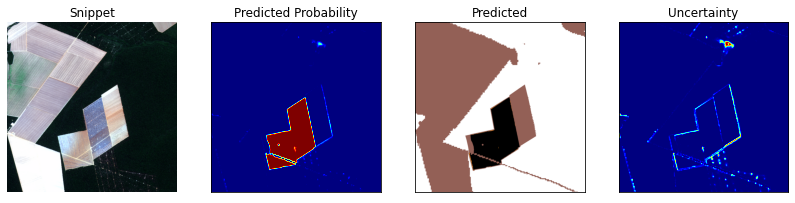

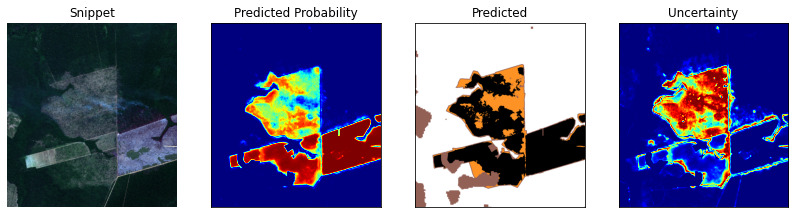

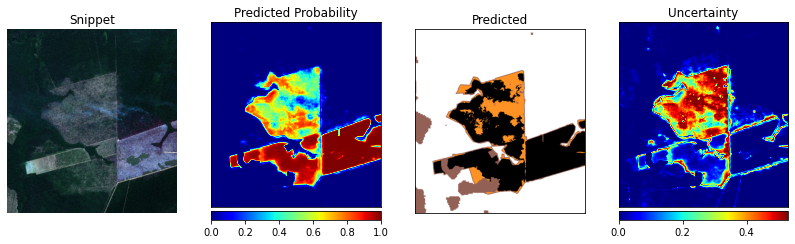

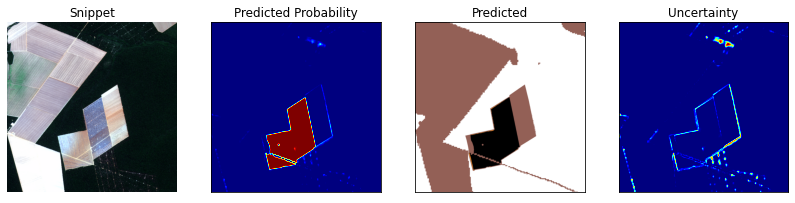

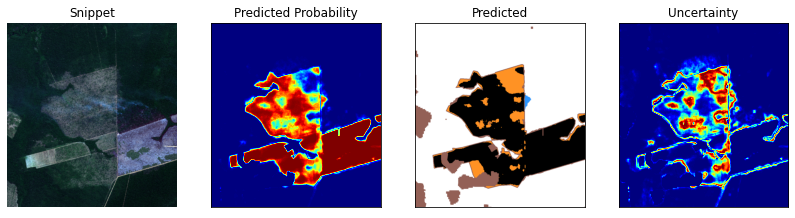

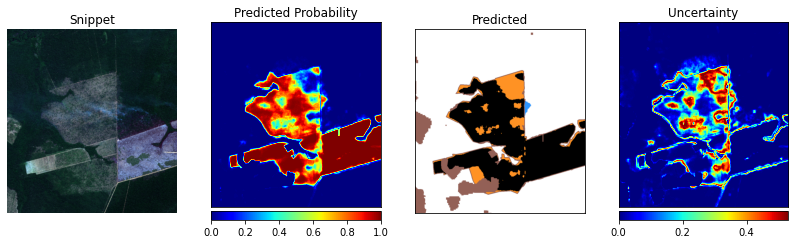

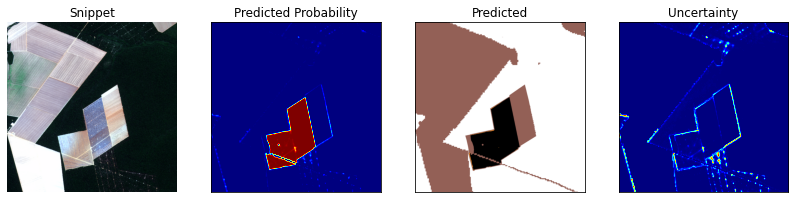

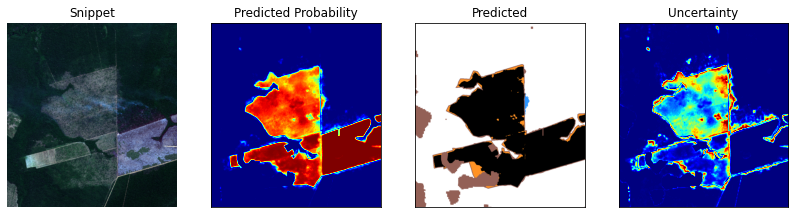

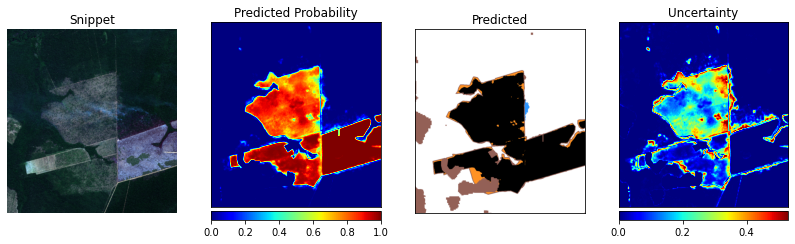

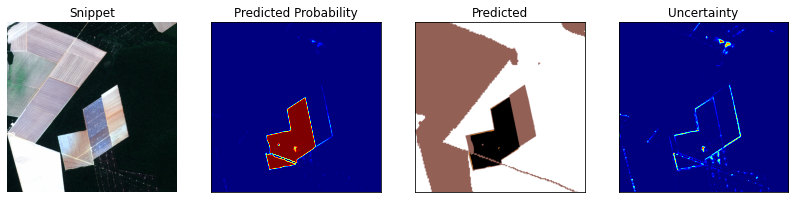

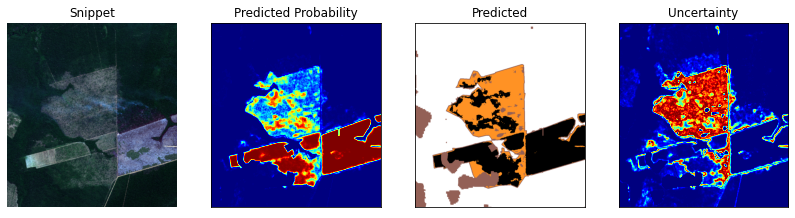

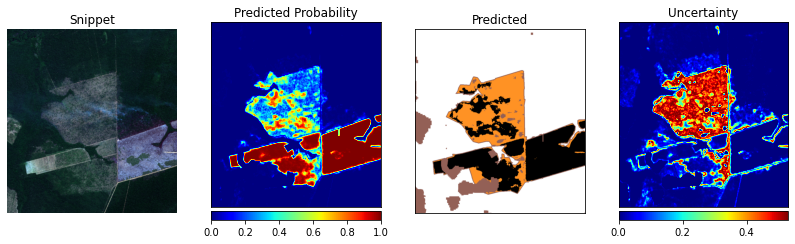

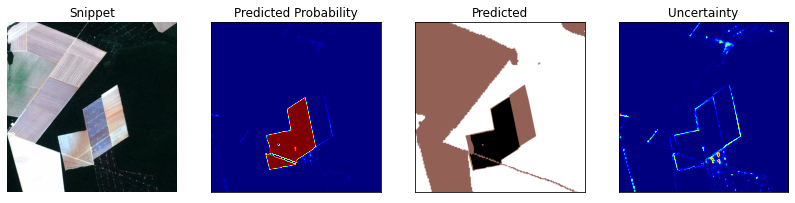

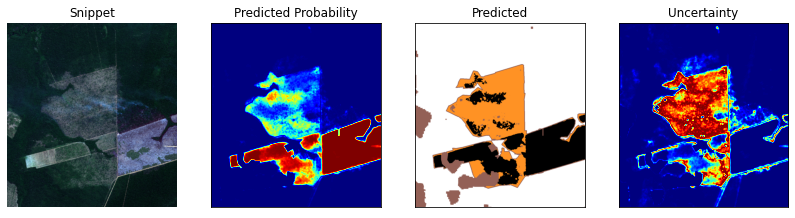

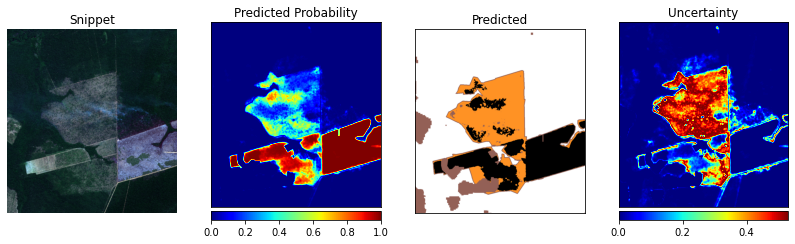

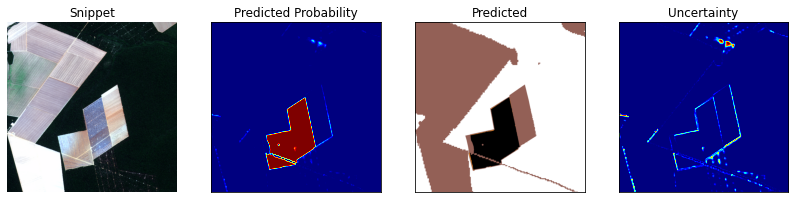

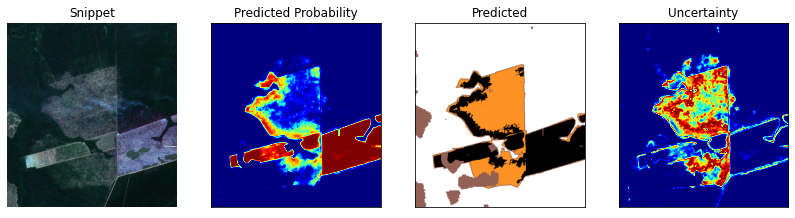

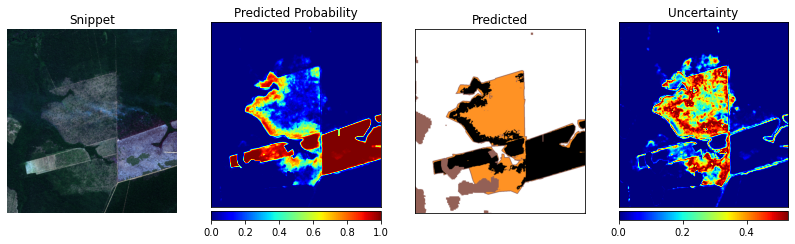

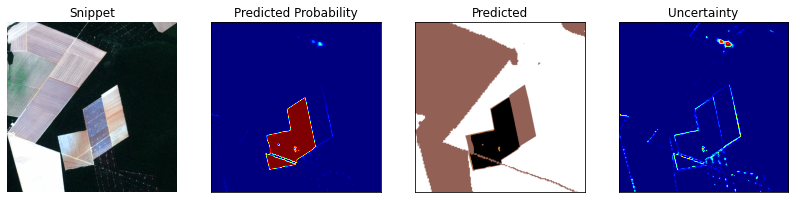

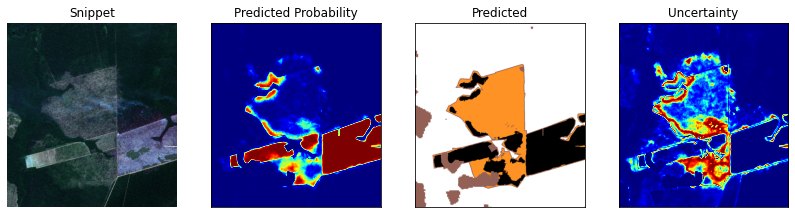

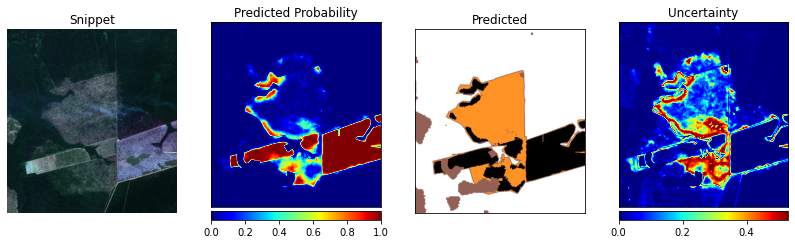

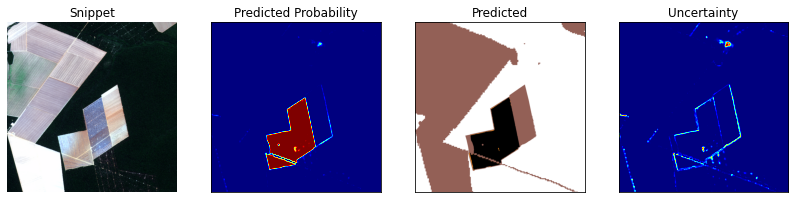

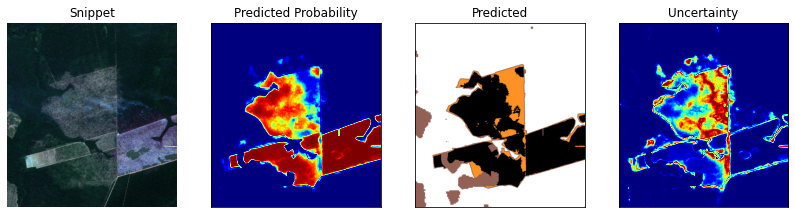

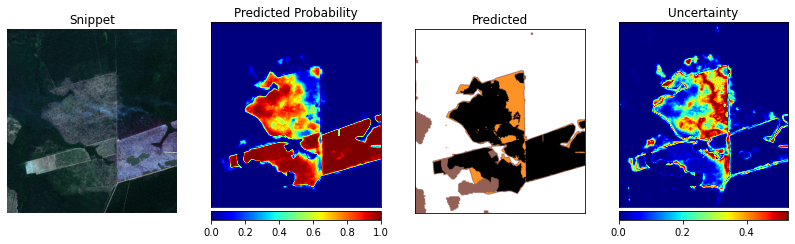

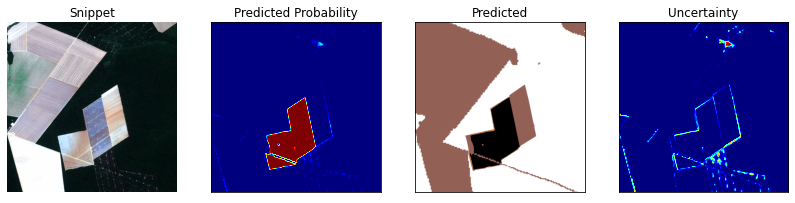

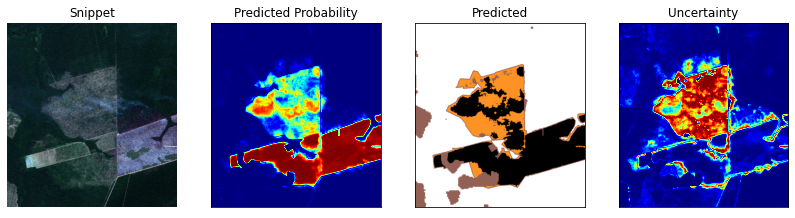

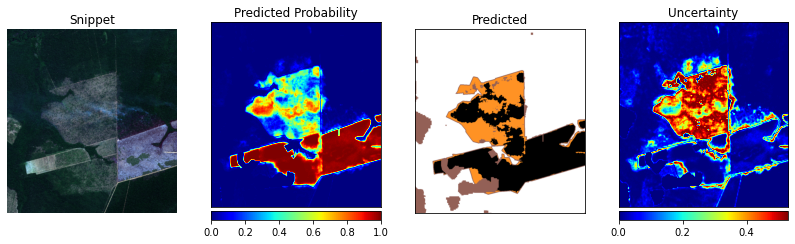

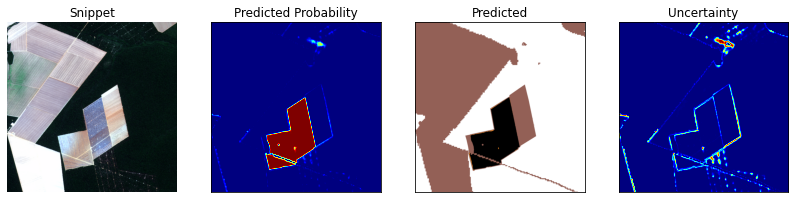

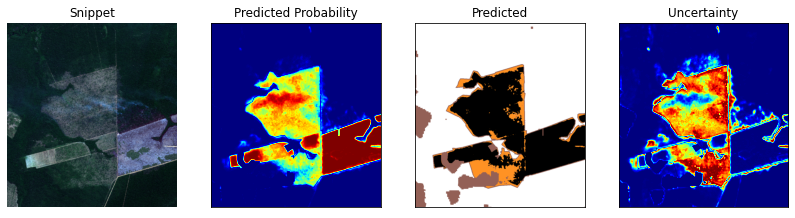

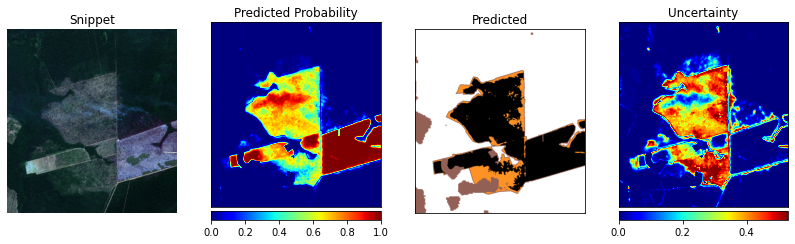

In [10]:
if config['inferring'] == True:
    idx = 0
    results = []
    error_count = 0

    while idx < len(exp_ids):
    # for experiment_value, exp_id in zip(experiment_values, exp_ids):
        try:

            print("Beginning run number {}".format(idx))
            logger = Logger()
            trainer = trainer_class(config, dataset, patchesHandler, logger)
            print("trainer.config", trainer.config)

            trainer.defineExperiment(exp_ids[idx])

            trainer.setExperimentPath()
            trainer.createLogFolders()

            trainer.loadDataset()

            # %%
            result = trainer.run_predictor()
            print("Result idx {}: {}".format(idx, result))
            results.append(result)


            with open(trainer.default_log_name, 'wb') as f:
                pickle.dump(results, f)
            print("Grid execution idx: {}".format(idx))
            idx += 1
            print("Grid execution idx: {}".format(idx))
            error_count = 0
        except Exception as e: 
            print(traceback.format_exc())
            error_count += 1
            if error_count > 10:
                sys.exit()
            print("Execution error in idx {}. Retrying...".format(idx))
            continue

In [11]:
error_count

0

In [12]:
print(results)

[{'other_uncertainty_metrics': {'sUEO': 0.7833864091210807, 'ece_score': 0.0060978415706352245}, 'uncertainty_result': {'metrics': {'precision_L': array([0.79001467]), 'recall_L': array([0.96880623]), 'recall_Ltotal': array([0.60721605]), 'AA': array([0.03000156]), 'precision_H': array([0.63928456]), 'recall_H': array([0.62302052]), 'UEO': array([0.15622741]), 'f1_L': array([0.87032299]), 'f1_H': array([0.63104776]), 'f1': 78.76}, 'metrics_audited': {'precision': array([0.8586521]), 'recall': array([0.98044877]), 'f1': array([0.91551737])}, 'exp': 108}}, {'other_uncertainty_metrics': {'sUEO': 0.8067601893828018, 'ece_score': 0.005223661616781386}, 'uncertainty_result': {'metrics': {'precision_L': array([0.86958199]), 'recall_L': array([0.9612442]), 'recall_Ltotal': array([0.65496428]), 'AA': array([0.03000127]), 'precision_H': array([0.53928499]), 'recall_H': array([0.62335843]), 'UEO': array([0.17244452]), 'f1_L': array([0.91311851]), 'f1_H': array([0.57828194]), 'f1': 80.47}, 'metric

In [13]:
print(len(results))

10


In [14]:
results[0]

{'other_uncertainty_metrics': {'sUEO': 0.7833864091210807,
  'ece_score': 0.0060978415706352245},
 'uncertainty_result': {'metrics': {'precision_L': array([0.79001467]),
   'recall_L': array([0.96880623]),
   'recall_Ltotal': array([0.60721605]),
   'AA': array([0.03000156]),
   'precision_H': array([0.63928456]),
   'recall_H': array([0.62302052]),
   'UEO': array([0.15622741]),
   'f1_L': array([0.87032299]),
   'f1_H': array([0.63104776]),
   'f1': 78.76},
  'metrics_audited': {'precision': array([0.8586521]),
   'recall': array([0.98044877]),
   'f1': array([0.91551737])},
  'exp': 108}}

In [15]:
trainer.f1

82.41

In [16]:
print(trainer.f1)

82.41
